# Fine-tune SAM 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient

import neptune
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [2]:
##%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.npz_files = sorted(os.listdir(self.data_root)) 
        self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
        # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
        # as an alternative, you can also use a list of npy files and load them one by one
        self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
        self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")

    def __len__(self):
        return self.ori_gts.shape[0]
    
    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]        
        
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()

In [21]:
# # # %% test dataset class and dataloader
# npz_tr_path = 'data/demo2D_vit_b'
# demo_dataset = NpzDataset(npz_tr_path)
# demo_dataloader = DataLoader(demo_dataset, batch_size=8, shuffle=True)
# for img_embed, gt2D, bboxes in demo_dataloader:
#     # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
#     print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
#     break

In [28]:
pwd

'D:\\medsam\\MedSAM-0.1'

In [7]:
run = neptune.init_run(
    project="nguyennhan8521/medsam",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3NTdkNGM5OS04MjViLTRhMzgtOWNkMy02N2Y3MDI5YjgxZDQifQ==",
) 

https://app.neptune.ai/nguyennhan8521/medsam/e/MEDSAM-42


In [9]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = 'data/demo2D_vit_b/2024_03_07'
work_dir = './work_dir'
task_name = 'demo2D'
# prepare SAM model
model_type = 'vit_b'
checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
total_params = sum(p.numel() for p in sam_model.mask_decoder.parameters())
print("Total number of parameters in the mask_decoder:", total_params)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

run['information'] = {
    'model_type' : 'vit_b',
    'checkpoint' : 'work_dir/SAM/sam_vit_b_01ec64.pth',
    'device' : 'cuda:0',
    "encoder_parameters": total_params
}


Total number of parameters in the mask_decoder: 4058340


In [ ]:
##%% train
num_epochs = 10000
batch_size = 64
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
run["parameters"] = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "optimizer": "adam"
}

for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    run["train/epoch/loss"].append(epoch_loss)
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest_flipchip.pth'))
    # run["model/weights"].upload(sam_model.state_dict())
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best_flipchip.pth'))


# plot loss
fig, ax = plt.subplots( nrows=1, ncols=1 )
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
fig.savefig(join(model_save_path, 'train_loss.png'))
plt.close(fig)

# You can also upload plot objects directly
run["train/loss"].upload(join(model_save_path, 'train_loss.png'))

run.stop()

self.img_embeddings.shape=(810, 256, 64, 64), self.ori_gts.shape=(810, 256, 256)


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 0, Loss: 1.5797096490859985


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1, Loss: 0.714114303390185


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 2, Loss: 0.3113332763314247


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 3, Loss: 0.24176907042662302


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


EPOCH: 4, Loss: 0.22096132238705954


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 5, Loss: 0.20980312799414


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 6, Loss: 0.20309938490390778


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 7, Loss: 0.19722736005981764


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 8, Loss: 0.1932446906963984


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 9, Loss: 0.1894136182963848


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 10, Loss: 0.18594690784811974


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 11, Loss: 0.1833402340610822


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 12, Loss: 0.1808552692333857


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 13, Loss: 0.17811532318592072


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 14, Loss: 0.17631463830669722


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 15, Loss: 0.1740389441450437


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 16, Loss: 0.17213552569349608


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 17, Loss: 0.1705922024945418


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 18, Loss: 0.16893946006894112


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 19, Loss: 0.16746477534373602


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 20, Loss: 0.16609023635586104


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 21, Loss: 0.16444639985760054


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 22, Loss: 0.16348999987045923


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 23, Loss: 0.1620655506849289


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 24, Loss: 0.160555991033713


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 25, Loss: 0.15944008032480875


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 26, Loss: 0.15831606338421503


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 27, Loss: 0.1569244588414828


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 28, Loss: 0.1558319628238678


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


EPOCH: 29, Loss: 0.1548528497417768


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 30, Loss: 0.1540634073317051


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 31, Loss: 0.15236792713403702


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 32, Loss: 0.15150146434704462


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 33, Loss: 0.15046992028752962


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 34, Loss: 0.14944958438475928


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 35, Loss: 0.14815669506788254


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 36, Loss: 0.14732390642166138


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 37, Loss: 0.14652261634667715


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 38, Loss: 0.14522812267144522


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 39, Loss: 0.14466976498564085


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 40, Loss: 0.14362497379382452


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 41, Loss: 0.14298749963442484


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 42, Loss: 0.1422404982149601


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 43, Loss: 0.14144648984074593


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 44, Loss: 0.1407731200257937


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 45, Loss: 0.14021891603867212


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 46, Loss: 0.13947141294678053


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 47, Loss: 0.13872494300206503


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 48, Loss: 0.13798840281864008


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 49, Loss: 0.13738510633508363


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 50, Loss: 0.1367452535778284


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


EPOCH: 51, Loss: 0.13617372450729212


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


EPOCH: 52, Loss: 0.1354531484345595


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 53, Loss: 0.1350319186846415


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 54, Loss: 0.13437142098943392


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 55, Loss: 0.1339609306305647


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 56, Loss: 0.13316895129779974


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 57, Loss: 0.13265399324397245


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 58, Loss: 0.13232143161197504


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 59, Loss: 0.131673293809096


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 60, Loss: 0.13126030067602792


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 61, Loss: 0.13073566680153212


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 62, Loss: 0.13013554736971855


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 63, Loss: 0.12947997450828552


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 64, Loss: 0.12883025904496512


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 65, Loss: 0.12860811998446783


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


EPOCH: 66, Loss: 0.12827463634312153


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 67, Loss: 0.12770749938984713


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 68, Loss: 0.12722927145659924


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 69, Loss: 0.12682131305336952


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 70, Loss: 0.126215947791934


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 71, Loss: 0.1258909460157156


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 72, Loss: 0.12561902590095997


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 73, Loss: 0.12493215252955754


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 74, Loss: 0.12463019415736198


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 75, Loss: 0.12449389696121216


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 76, Loss: 0.12373411903778712


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 77, Loss: 0.12352340295910835


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 78, Loss: 0.12291664319733779


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 79, Loss: 0.12258583431442578


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 80, Loss: 0.12236204246679942


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


EPOCH: 81, Loss: 0.1219798643141985


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 82, Loss: 0.12161034159362316


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 83, Loss: 0.12130883584419887


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 84, Loss: 0.12072414097686608


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 85, Loss: 0.12060534643630187


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 86, Loss: 0.12005571958919366


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 87, Loss: 0.11980840563774109


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 88, Loss: 0.11955545656383038


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 89, Loss: 0.11915416705111663


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 90, Loss: 0.11858651973307133


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 91, Loss: 0.11842557539542516


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 92, Loss: 0.11799974429110686


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 93, Loss: 0.11776021060844262


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 94, Loss: 0.11752062663435936


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 95, Loss: 0.11744944627086322


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 96, Loss: 0.1169584517677625


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 97, Loss: 0.11655635635058086


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 98, Loss: 0.11628720971445243


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 99, Loss: 0.11593797989189625


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 100, Loss: 0.11564573335150878


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 101, Loss: 0.11529738704363506


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 102, Loss: 0.11484977354605992


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


EPOCH: 103, Loss: 0.11479506579538186


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 104, Loss: 0.11428012947241466


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 105, Loss: 0.11416065382460754


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 106, Loss: 0.11382493128379186


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 107, Loss: 0.11357973391811053


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 108, Loss: 0.11335630714893341


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 109, Loss: 0.11305401474237442


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 110, Loss: 0.11281586190064748


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 111, Loss: 0.11268238102396329


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 112, Loss: 0.11237954037884872


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 113, Loss: 0.11217834614217281


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 114, Loss: 0.11185466373960178


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 115, Loss: 0.11142947959403197


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 116, Loss: 0.11131843986610572


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 117, Loss: 0.11097213998436928


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 118, Loss: 0.11105223434666793


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 119, Loss: 0.11073361895978451


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 120, Loss: 0.11020516666273276


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 121, Loss: 0.11011010656754176


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 122, Loss: 0.10986329801380634


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 123, Loss: 0.10990365408360958


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 124, Loss: 0.109602564945817


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 125, Loss: 0.10915539848307769


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 126, Loss: 0.10893116580943267


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 127, Loss: 0.10868605598807335


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 128, Loss: 0.10835598222911358


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 129, Loss: 0.10805018121997516


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 130, Loss: 0.10799780301749706


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 131, Loss: 0.10759794774154822


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 132, Loss: 0.10754874472816785


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 133, Loss: 0.10747890857358773


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 134, Loss: 0.10733680861691634


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 135, Loss: 0.10685017084081967


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 136, Loss: 0.10689439934988816


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 137, Loss: 0.10661043350895245


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


EPOCH: 138, Loss: 0.10632894684871037


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 139, Loss: 0.1060629915446043


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 140, Loss: 0.10609478875994682


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 141, Loss: 0.10572235099971294


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 142, Loss: 0.10562869720160961


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 143, Loss: 0.10544994721810023


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 144, Loss: 0.10522877052426338


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 145, Loss: 0.10509162147839864


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 146, Loss: 0.10491970678170522


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 147, Loss: 0.10481942196687062


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 148, Loss: 0.1045890524983406


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 149, Loss: 0.10440921535094579


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 150, Loss: 0.1040808701266845


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 151, Loss: 0.10389527678489685


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 152, Loss: 0.10369254400332768


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 153, Loss: 0.10357646644115448


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 154, Loss: 0.10354906258483727


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 155, Loss: 0.10316743515431881


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 156, Loss: 0.10290127992630005


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 157, Loss: 0.10290648167332013


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 158, Loss: 0.10276871298750241


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 159, Loss: 0.10260219189027946


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 160, Loss: 0.10231924243271351


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 161, Loss: 0.10203955881297588


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 162, Loss: 0.10201053321361542


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 163, Loss: 0.10167250906427701


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 164, Loss: 0.10159803554415703


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 165, Loss: 0.10146721514562766


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 166, Loss: 0.10135122947394848


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 167, Loss: 0.10109896895786126


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 168, Loss: 0.10092357608179252


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 169, Loss: 0.10065019192794959


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 170, Loss: 0.10080862604081631


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 171, Loss: 0.10040246198574702


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 172, Loss: 0.10012832470238209


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 173, Loss: 0.09985872233907382


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 174, Loss: 0.09987105304996173


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 175, Loss: 0.0997866801917553


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 176, Loss: 0.09962872788310051


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 177, Loss: 0.09935169853270054


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 178, Loss: 0.0993344858288765


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 179, Loss: 0.09923051111400127


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 180, Loss: 0.09902450380225976


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 181, Loss: 0.09877259718875091


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 182, Loss: 0.09864338487386703


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 183, Loss: 0.09856425101558368


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 184, Loss: 0.09850858959058921


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 185, Loss: 0.09825658177336057


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 186, Loss: 0.09819730805854003


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 187, Loss: 0.0980175534884135


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 188, Loss: 0.09779773155848186


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 189, Loss: 0.09756945197780927


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 190, Loss: 0.09743803304930528


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 191, Loss: 0.09751741029322147


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 192, Loss: 0.09726689818004768


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 193, Loss: 0.09711166098713875


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 194, Loss: 0.097109105437994


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 195, Loss: 0.09669928252696991


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 196, Loss: 0.09660620739062627


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 197, Loss: 0.09637719579041004


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 198, Loss: 0.09633673292895158


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 199, Loss: 0.09634427043298881


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 200, Loss: 0.09608177033563454


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 201, Loss: 0.09595279209315777


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 202, Loss: 0.09574468309680621


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 203, Loss: 0.09579343783358733


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 204, Loss: 0.09578618345161279


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 205, Loss: 0.09539747486511867


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 206, Loss: 0.09519862818221252


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 207, Loss: 0.09497410741945107


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 208, Loss: 0.09504162644346555


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 209, Loss: 0.09488955574731033


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 210, Loss: 0.09476413391530514


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 211, Loss: 0.09481214235226314


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 212, Loss: 0.09449395102759202


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 213, Loss: 0.09441671582559745


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 214, Loss: 0.09427970585723718


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 215, Loss: 0.09418478359778722


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 216, Loss: 0.09394932972888152


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 217, Loss: 0.09368362091481686


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 218, Loss: 0.09370499042173226


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 219, Loss: 0.09360069905718167


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 220, Loss: 0.09342696083088715


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 221, Loss: 0.09326369067033131


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 222, Loss: 0.09308012140293916


100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


EPOCH: 223, Loss: 0.09319964237511158


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 224, Loss: 0.09304126972953479


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 225, Loss: 0.09292867283026378


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 226, Loss: 0.09286559311052163


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 227, Loss: 0.09276192262768745


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 228, Loss: 0.09253012451032798


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 229, Loss: 0.09233228551844756


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 230, Loss: 0.09221783839166164


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


EPOCH: 231, Loss: 0.09207330271601677


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 232, Loss: 0.09192434636255105


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 233, Loss: 0.09201022361715634


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 234, Loss: 0.09193250785271327


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 235, Loss: 0.09190599620342255


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 236, Loss: 0.0919708243260781


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 237, Loss: 0.0915359656016032


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 238, Loss: 0.09134192143877347


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 239, Loss: 0.091101398691535


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 240, Loss: 0.0910144013663133


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 241, Loss: 0.09114205154279868


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 242, Loss: 0.09090687148272991


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 243, Loss: 0.0906758780280749


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 244, Loss: 0.09064831025898457


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 245, Loss: 0.09045785541335742


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 246, Loss: 0.09047051146626472


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 247, Loss: 0.09024873562157154


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 248, Loss: 0.09031389094889164


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 249, Loss: 0.09010464449723561


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 250, Loss: 0.0898524858057499


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 251, Loss: 0.08976742066442966


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 252, Loss: 0.08993113599717617


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 253, Loss: 0.09000447516640027


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 254, Loss: 0.0896576518813769


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 255, Loss: 0.08935684897005558


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 256, Loss: 0.08943731275697549


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 257, Loss: 0.08919035519162814


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 258, Loss: 0.08911985096832116


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 259, Loss: 0.08920259773731232


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 260, Loss: 0.08893888629972935


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 261, Loss: 0.08897552080452442


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 262, Loss: 0.08874855314691861


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 263, Loss: 0.08881222394605477


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 264, Loss: 0.0883800412217776


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 265, Loss: 0.08846578312416871


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 266, Loss: 0.08842796335617702


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 267, Loss: 0.08824930464227994


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 268, Loss: 0.08829391685624917


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 269, Loss: 0.0881235475341479


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 270, Loss: 0.08817236435910066


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 271, Loss: 0.08790518653889497


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 272, Loss: 0.08765657804906368


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 273, Loss: 0.08752923707167308


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 274, Loss: 0.08748179860413074


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 275, Loss: 0.0876753485451142


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


EPOCH: 276, Loss: 0.08740199667712052


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 277, Loss: 0.08743860696752866


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 278, Loss: 0.08720108928779761


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 279, Loss: 0.08700457277397315


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 280, Loss: 0.086954806620876


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 281, Loss: 0.08723747978607814


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 282, Loss: 0.0869519580155611


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 283, Loss: 0.08673501573503017


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 284, Loss: 0.08657915455599625


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 285, Loss: 0.08647843139866988


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 286, Loss: 0.08655101868013541


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 287, Loss: 0.08657267938057582


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 288, Loss: 0.08637976025541623


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 289, Loss: 0.08633754961192608


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 290, Loss: 0.08621233329176903


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 291, Loss: 0.08592011717458566


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 292, Loss: 0.08587384968996048


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 293, Loss: 0.08591994394858678


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 294, Loss: 0.08595658155779044


100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


EPOCH: 295, Loss: 0.08559680978457133


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 296, Loss: 0.08549663114051025


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 297, Loss: 0.08555105763177077


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 298, Loss: 0.0853631633023421


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 299, Loss: 0.08523919867972533


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 300, Loss: 0.08536978376408418


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 301, Loss: 0.0856141522526741


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 302, Loss: 0.08545502213140328


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 303, Loss: 0.08533801448841889


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 304, Loss: 0.08494636788964272


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 305, Loss: 0.08503744192421436


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 306, Loss: 0.08476436510682106


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 307, Loss: 0.08489887540539105


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 308, Loss: 0.08453277684748173


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 309, Loss: 0.08458654955029488


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 310, Loss: 0.08440957466761272


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


EPOCH: 311, Loss: 0.08429018159707387


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 312, Loss: 0.08406994553903739


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 313, Loss: 0.08424498264988263


100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


EPOCH: 314, Loss: 0.08391940717895825


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 315, Loss: 0.08398499712347984


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 316, Loss: 0.08407659518222015


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 317, Loss: 0.08405630042155583


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 318, Loss: 0.08403550647199154


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 319, Loss: 0.08383551612496376


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 320, Loss: 0.08381065850456555


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 321, Loss: 0.0835378219683965


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 322, Loss: 0.08344767366846402


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 323, Loss: 0.0834789617607991


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 324, Loss: 0.08349953343470891


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 325, Loss: 0.0833518182237943


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 326, Loss: 0.08310396534701188


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 327, Loss: 0.08309085667133331


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 328, Loss: 0.08319220381478469


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 329, Loss: 0.08310411311686039


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 330, Loss: 0.0828516526768605


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 331, Loss: 0.0828113251676162


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 332, Loss: 0.08281749859452248


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 333, Loss: 0.08272551434735458


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 334, Loss: 0.08259894512593746


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 335, Loss: 0.08256128927071889


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 336, Loss: 0.08249057208498319


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 337, Loss: 0.08226020137468974


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 338, Loss: 0.08202323627968629


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 339, Loss: 0.08207886603971322


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 340, Loss: 0.08216522509853046


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 341, Loss: 0.08219754757980506


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 342, Loss: 0.0820298803349336


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 343, Loss: 0.08202776995797952


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 344, Loss: 0.08197825277845065


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 345, Loss: 0.08189766605695088


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 346, Loss: 0.0818121749907732


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 347, Loss: 0.0815709928671519


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 348, Loss: 0.08150508813560009


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 349, Loss: 0.08146929430464904


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 350, Loss: 0.0816282747934262


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 351, Loss: 0.08156078805526097


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 352, Loss: 0.08120158004264037


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 353, Loss: 0.08124895890553792


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 354, Loss: 0.08113102118174235


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 355, Loss: 0.0809044527510802


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 356, Loss: 0.0813087069739898


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 357, Loss: 0.08123453830679257


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 358, Loss: 0.08139411608378093


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 359, Loss: 0.08101985789835453


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 360, Loss: 0.08099335183699925


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 361, Loss: 0.0809507326533397


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 362, Loss: 0.08097441432376702


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 363, Loss: 0.08063224330544472


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 364, Loss: 0.08045180576543014


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 365, Loss: 0.0803417544811964


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 366, Loss: 0.08029996727903684


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 367, Loss: 0.08031385329862435


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 368, Loss: 0.08027380332350731


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 369, Loss: 0.08031498144070308


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 370, Loss: 0.08002892695367336


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 371, Loss: 0.08000965230166912


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 372, Loss: 0.07985478080809116


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 373, Loss: 0.07990151147047679


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 374, Loss: 0.07982536405324936


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 375, Loss: 0.07976244265834491


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 376, Loss: 0.07963267527520657


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 377, Loss: 0.07963177065054576


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 378, Loss: 0.07984275681277116


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 379, Loss: 0.0795850542684396


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 380, Loss: 0.0795238446444273


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 381, Loss: 0.07910349840919177


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 382, Loss: 0.07913324857751529


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 383, Loss: 0.07899795286357403


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 384, Loss: 0.07918253913521767


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 385, Loss: 0.07916659861803055


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 386, Loss: 0.07942876840631168


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 387, Loss: 0.07900862768292427


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 388, Loss: 0.07893542324503262


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 389, Loss: 0.07871373121937116


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 390, Loss: 0.07855667484303315


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 391, Loss: 0.07869857425491016


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 392, Loss: 0.07862871202329795


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 393, Loss: 0.07857891047994296


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 394, Loss: 0.07854334264993668


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 395, Loss: 0.07851647399365902


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 396, Loss: 0.07840424217283726


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 397, Loss: 0.0781974804898103


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 398, Loss: 0.07819851798315842


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 399, Loss: 0.07794468787809213


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 400, Loss: 0.07803284376859665


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 401, Loss: 0.07800021208822727


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 402, Loss: 0.07812894694507122


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 403, Loss: 0.0778193548321724


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 404, Loss: 0.07785329346855481


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 405, Loss: 0.07790538606544335


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 406, Loss: 0.07788039868076642


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 407, Loss: 0.07789456099271774


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 408, Loss: 0.07771030130485694


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 409, Loss: 0.07754297430316608


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 410, Loss: 0.07753038468460242


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 411, Loss: 0.0775727288176616


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 412, Loss: 0.07724147414167722


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 413, Loss: 0.07743261568248272


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 414, Loss: 0.07723179273307323


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 415, Loss: 0.07712183644374211


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 416, Loss: 0.07723917191227277


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 417, Loss: 0.07707509398460388


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 418, Loss: 0.07703217926124732


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 419, Loss: 0.07679298209647338


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 420, Loss: 0.07686055141190688


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 421, Loss: 0.07678874644140403


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 422, Loss: 0.07672098527352016


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 423, Loss: 0.07649457640945911


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 424, Loss: 0.07647368560234706


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


EPOCH: 425, Loss: 0.07693270035088062


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 426, Loss: 0.07694491185247898


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 427, Loss: 0.07691511511802673


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 428, Loss: 0.0768733328829209


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 429, Loss: 0.07616294485827287


100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


EPOCH: 430, Loss: 0.0762467918296655


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 431, Loss: 0.0762779066960017


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


EPOCH: 432, Loss: 0.076310183852911


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 433, Loss: 0.07611246344943841


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 434, Loss: 0.07582208700478077


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 435, Loss: 0.07596300852795441


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 436, Loss: 0.07590414086977641


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 437, Loss: 0.07578265480697155


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 438, Loss: 0.07580729015171528


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 439, Loss: 0.07569485778609912


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 440, Loss: 0.07598200129965942


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 441, Loss: 0.07580828418334325


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 442, Loss: 0.0755310207605362


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 443, Loss: 0.0754091665148735


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 444, Loss: 0.07528573833405972


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 445, Loss: 0.07541960602005322


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 446, Loss: 0.07520225395758946


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 447, Loss: 0.07518264216681321


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 448, Loss: 0.0752680425842603


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 449, Loss: 0.07529726810753345


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 450, Loss: 0.07524420320987701


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


EPOCH: 451, Loss: 0.07511014801760514


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 452, Loss: 0.0750402429451545


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 453, Loss: 0.0748458206653595


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 454, Loss: 0.07482294303675492


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 455, Loss: 0.07510716033478577


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


EPOCH: 456, Loss: 0.07491869231065114


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 457, Loss: 0.07479140721261501


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 458, Loss: 0.07458857012291749


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 459, Loss: 0.074623242020607


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 460, Loss: 0.07464805680016677


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 461, Loss: 0.07478903420269489


100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


EPOCH: 462, Loss: 0.07448173686861992


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 463, Loss: 0.07444556926687558


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 464, Loss: 0.07449629840751489


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 465, Loss: 0.07428549975156784


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 466, Loss: 0.0742673712472121


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 467, Loss: 0.07422740447024505


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 468, Loss: 0.07423174443344276


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 469, Loss: 0.07427340062956016


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 470, Loss: 0.07404088042676449


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 471, Loss: 0.073824401323994


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 472, Loss: 0.07382998429238796


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 473, Loss: 0.07380932755768299


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 474, Loss: 0.07371053472161293


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 475, Loss: 0.07382809494932492


100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


EPOCH: 476, Loss: 0.07372089227040608


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 477, Loss: 0.07368993138273557


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


EPOCH: 478, Loss: 0.07371440095206101


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 479, Loss: 0.07344075478613377


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


EPOCH: 480, Loss: 0.07357904687523842


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 481, Loss: 0.07343454410632451


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


EPOCH: 482, Loss: 0.07361184743543465


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


EPOCH: 483, Loss: 0.07347320889433225


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


EPOCH: 484, Loss: 0.0732689369469881


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


EPOCH: 485, Loss: 0.07306914838651817


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 486, Loss: 0.07301217565933864


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


EPOCH: 487, Loss: 0.07301926116148631


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 488, Loss: 0.07296460246046384


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


EPOCH: 489, Loss: 0.07300288478533427


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


EPOCH: 490, Loss: 0.07295758215089639


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 491, Loss: 0.07301081468661626


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 492, Loss: 0.07300434323648612


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


EPOCH: 493, Loss: 0.07280643905202548


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


EPOCH: 494, Loss: 0.07281175752480824


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


EPOCH: 495, Loss: 0.0728862602263689


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 496, Loss: 0.07282622593144576


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 497, Loss: 0.07308923204739888


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 498, Loss: 0.07295499897251527


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 499, Loss: 0.07245975422362487


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


EPOCH: 500, Loss: 0.07231484229365985


100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


EPOCH: 501, Loss: 0.07247115361193816


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


EPOCH: 502, Loss: 0.0722367192308108


100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


EPOCH: 503, Loss: 0.07231237428883712


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 504, Loss: 0.07217261008918285


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 505, Loss: 0.07208984283109506


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


EPOCH: 506, Loss: 0.07242355619867642


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 507, Loss: 0.07218320698787768


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 508, Loss: 0.07190240174531937


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


EPOCH: 509, Loss: 0.07200820216288169


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 510, Loss: 0.07189722917973995


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


EPOCH: 511, Loss: 0.07185149937868118


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 512, Loss: 0.0719690111776193


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


EPOCH: 513, Loss: 0.07185787645479043


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 514, Loss: 0.0717082569996516


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 515, Loss: 0.07175734701255958


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 516, Loss: 0.07173488475382328


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 517, Loss: 0.07143155547479789


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 518, Loss: 0.0715826569745938


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 519, Loss: 0.07144238830854495


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


EPOCH: 520, Loss: 0.07146129198372364


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 521, Loss: 0.07137032287816207


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


EPOCH: 522, Loss: 0.07115866554280122


100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


EPOCH: 523, Loss: 0.0711446472754081


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 524, Loss: 0.07110378704965115


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 525, Loss: 0.07103077135980129


100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


EPOCH: 526, Loss: 0.0711609988162915


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


EPOCH: 527, Loss: 0.07099956025679906


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 528, Loss: 0.07112651783972979


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


EPOCH: 529, Loss: 0.0710739033917586


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 530, Loss: 0.07124372726927201


100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


EPOCH: 531, Loss: 0.07143564087649186


100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


EPOCH: 532, Loss: 0.07128053779403369


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


EPOCH: 533, Loss: 0.07091694449385007


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


EPOCH: 534, Loss: 0.07059488818049431


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


EPOCH: 535, Loss: 0.07074627683808406


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 536, Loss: 0.07059424463659525


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


EPOCH: 537, Loss: 0.07043854426592588


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


EPOCH: 538, Loss: 0.07043914124369621


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 539, Loss: 0.07040596598138411


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


EPOCH: 540, Loss: 0.07049220117429893


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 541, Loss: 0.07025860125819842


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 542, Loss: 0.07035008817911148


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


EPOCH: 543, Loss: 0.0704198032617569


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


EPOCH: 544, Loss: 0.07037389930337667


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


EPOCH: 545, Loss: 0.07060677961756785


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


EPOCH: 546, Loss: 0.07007844559848309


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


EPOCH: 547, Loss: 0.07024372400095065


100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


EPOCH: 548, Loss: 0.07002265844494104


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 549, Loss: 0.06993825268000364


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


EPOCH: 550, Loss: 0.07010355933258931


100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


EPOCH: 551, Loss: 0.06992235655585925


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


EPOCH: 552, Loss: 0.0699842715015014


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 553, Loss: 0.0697754118591547


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


EPOCH: 554, Loss: 0.06978860838959615


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 555, Loss: 0.06995358721663554


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


EPOCH: 556, Loss: 0.06992376875132322


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 557, Loss: 0.06978295898685853


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


EPOCH: 558, Loss: 0.06981037215640147


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 559, Loss: 0.06989303044974804


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


EPOCH: 560, Loss: 0.07002398340652387


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


EPOCH: 561, Loss: 0.0696781234194835


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 562, Loss: 0.06957938304791848


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


EPOCH: 563, Loss: 0.0697490085537235


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


EPOCH: 564, Loss: 0.06951192673295736


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 565, Loss: 0.06928427113840978


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 566, Loss: 0.06935555146386226


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


EPOCH: 567, Loss: 0.0692021648089091


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 568, Loss: 0.06894863986720641


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 569, Loss: 0.06927610747516155


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


EPOCH: 570, Loss: 0.06935602147132158


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


EPOCH: 571, Loss: 0.06911285469929378


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 572, Loss: 0.06915098428726196


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


EPOCH: 573, Loss: 0.06876241819312175


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


EPOCH: 574, Loss: 0.06882251550753911


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


EPOCH: 575, Loss: 0.06874675862491131


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


EPOCH: 576, Loss: 0.0687156617641449


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 577, Loss: 0.06880957478036483


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 578, Loss: 0.06894250555584829


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


EPOCH: 579, Loss: 0.06870946722726028


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 580, Loss: 0.06855244313677152


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 581, Loss: 0.06856727786362171


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


EPOCH: 582, Loss: 0.06865889392793179


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 583, Loss: 0.06862822454422712


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 584, Loss: 0.06869611113021772


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


EPOCH: 585, Loss: 0.06851129202793042


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 586, Loss: 0.06839396338909864


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 587, Loss: 0.06831346390148003


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 588, Loss: 0.0684679349263509


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 589, Loss: 0.06815910463531812


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


EPOCH: 590, Loss: 0.06842890319724877


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


EPOCH: 591, Loss: 0.06817521372189124


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


EPOCH: 592, Loss: 0.06802406534552574


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 593, Loss: 0.06792337136964004


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


EPOCH: 594, Loss: 0.06789594329893589


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 595, Loss: 0.06789942520360152


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 596, Loss: 0.06789486824224393


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 597, Loss: 0.06772325250009696


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 598, Loss: 0.06771627285828193


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


EPOCH: 599, Loss: 0.06776073419799407


100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


EPOCH: 600, Loss: 0.06783870017776887


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


EPOCH: 601, Loss: 0.06790779531002045


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


EPOCH: 602, Loss: 0.06772077983866136


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 603, Loss: 0.06774300957719485


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


EPOCH: 604, Loss: 0.06754795803378026


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 605, Loss: 0.06743765342980623


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 606, Loss: 0.0675130517532428


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


EPOCH: 607, Loss: 0.06761229100326697


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


EPOCH: 608, Loss: 0.0674268426373601


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


EPOCH: 609, Loss: 0.0671781109025081


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 610, Loss: 0.06728719795743625


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 611, Loss: 0.06714358118673165


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 612, Loss: 0.06727812563379605


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


EPOCH: 613, Loss: 0.06734979680428903


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


EPOCH: 614, Loss: 0.06731295554588239


100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


EPOCH: 615, Loss: 0.06710165832191706


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


EPOCH: 616, Loss: 0.06697065103799105


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 617, Loss: 0.06703589794536431


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 618, Loss: 0.06704348139464855


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


EPOCH: 619, Loss: 0.06697004288434982


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


EPOCH: 620, Loss: 0.06685320784648259


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


EPOCH: 621, Loss: 0.06665444932878017


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


EPOCH: 622, Loss: 0.06688222102820873


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


EPOCH: 623, Loss: 0.06704030030717452


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 624, Loss: 0.06672594603151083


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


EPOCH: 625, Loss: 0.06664417963474989


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 626, Loss: 0.06667945037285487


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


EPOCH: 627, Loss: 0.06646585247168939


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


EPOCH: 628, Loss: 0.06656968407332897


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 629, Loss: 0.06638178788125515


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 630, Loss: 0.06656086631119251


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


EPOCH: 631, Loss: 0.06658225413411856


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


EPOCH: 632, Loss: 0.06662904905776183


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


EPOCH: 633, Loss: 0.0664181225001812


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 634, Loss: 0.06663854699581861


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 635, Loss: 0.06640670417497556


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


EPOCH: 636, Loss: 0.06625122452775638


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


EPOCH: 637, Loss: 0.06635670084506273


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


EPOCH: 638, Loss: 0.06636725397159655


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 639, Loss: 0.06607404754807551


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


EPOCH: 640, Loss: 0.0661567837620775


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


EPOCH: 641, Loss: 0.06609947110215823


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


EPOCH: 642, Loss: 0.0660718788082401


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


EPOCH: 643, Loss: 0.06602603166053693


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 644, Loss: 0.06610250535110633


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 645, Loss: 0.06603956719239552


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 646, Loss: 0.06604551027218501


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 647, Loss: 0.06599896680563688


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


EPOCH: 648, Loss: 0.06597039569169283


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


EPOCH: 649, Loss: 0.06588080680618684


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 650, Loss: 0.06578226666897535


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 651, Loss: 0.06563678911576669


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


EPOCH: 652, Loss: 0.0654716386149327


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


EPOCH: 653, Loss: 0.0655749598518014


100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


EPOCH: 654, Loss: 0.06552063891043265


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


EPOCH: 655, Loss: 0.06574960829069217


100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


EPOCH: 656, Loss: 0.06604794443895419


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


EPOCH: 657, Loss: 0.06588342941055696


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 658, Loss: 0.06550198731323083


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


EPOCH: 659, Loss: 0.06543666993578275


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


EPOCH: 660, Loss: 0.0650589174280564


100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


EPOCH: 661, Loss: 0.0653348204990228


100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


EPOCH: 662, Loss: 0.06510379848380883


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


EPOCH: 663, Loss: 0.06516641471534967


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


EPOCH: 664, Loss: 0.06522598800559838


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


EPOCH: 665, Loss: 0.06530641453961532


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


EPOCH: 666, Loss: 0.06527917366474867


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 667, Loss: 0.06488275652130444


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


EPOCH: 668, Loss: 0.0650675343349576


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


EPOCH: 669, Loss: 0.06497177388519049


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


EPOCH: 670, Loss: 0.06481199866781633


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


EPOCH: 671, Loss: 0.06473978950331609


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


EPOCH: 672, Loss: 0.06484376732259989


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 673, Loss: 0.06468069305022557


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 674, Loss: 0.06480735975007217


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


EPOCH: 675, Loss: 0.06460682488977909


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


EPOCH: 676, Loss: 0.06487591005861759


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


EPOCH: 677, Loss: 0.0649840400243799


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 678, Loss: 0.06491208635270596


100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


EPOCH: 679, Loss: 0.06491229155411322


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


EPOCH: 680, Loss: 0.0645493029927214


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 681, Loss: 0.06467403161029021


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


EPOCH: 682, Loss: 0.06477320535729329


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


EPOCH: 683, Loss: 0.06442954173932473


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


EPOCH: 684, Loss: 0.06423273279021184


100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


EPOCH: 685, Loss: 0.06409282454599936


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


EPOCH: 686, Loss: 0.06433491129428148


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


EPOCH: 687, Loss: 0.06431171142806609


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


EPOCH: 688, Loss: 0.06413917647053798


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


EPOCH: 689, Loss: 0.06415746298929055


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


EPOCH: 690, Loss: 0.06431259928892057


100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


EPOCH: 691, Loss: 0.06413797692706187


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


EPOCH: 692, Loss: 0.06398087088018656


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


EPOCH: 693, Loss: 0.06378655539204676


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


EPOCH: 694, Loss: 0.06395184497038524


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


EPOCH: 695, Loss: 0.06368883481870095


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 696, Loss: 0.06402569822967052


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 697, Loss: 0.06380057707428932


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 698, Loss: 0.0639343357955416


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 699, Loss: 0.0637565515935421


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 700, Loss: 0.06390626138697068


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 701, Loss: 0.06369861463705699


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 702, Loss: 0.06366684101521969


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 703, Loss: 0.06375791101406018


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 704, Loss: 0.06360135258485873


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 705, Loss: 0.06375028875966866


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 706, Loss: 0.06353614758700132


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 707, Loss: 0.06353317045917113


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 708, Loss: 0.06336774335553248


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 709, Loss: 0.06319697635869186


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 710, Loss: 0.06312901309380929


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 711, Loss: 0.06311005695412557


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 712, Loss: 0.06322566792368889


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 713, Loss: 0.06323068216443062


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 714, Loss: 0.06315779748062293


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 715, Loss: 0.06313921883702278


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 716, Loss: 0.0631913123652339


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 717, Loss: 0.0630874012907346


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 718, Loss: 0.06322955588499705


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 719, Loss: 0.06323729269206524


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 720, Loss: 0.06308047845959663


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 721, Loss: 0.06297360919415951


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 722, Loss: 0.06288812216371298


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 723, Loss: 0.06275104048351447


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 724, Loss: 0.06268376453469197


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 725, Loss: 0.06279121401409309


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 726, Loss: 0.06264603417366743


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 727, Loss: 0.06251410705347855


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 728, Loss: 0.06273398300011952


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 729, Loss: 0.0628343407685558


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 730, Loss: 0.06264614562193553


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 731, Loss: 0.0627538375556469


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 732, Loss: 0.06260634679347277


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 733, Loss: 0.06258353963494301


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 734, Loss: 0.062477732077240944


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 735, Loss: 0.06256601897378762


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 736, Loss: 0.062462043948471546


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 737, Loss: 0.06236292266597351


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 738, Loss: 0.06248518731445074


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 739, Loss: 0.06239334245522817


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 740, Loss: 0.062197375732163586


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 741, Loss: 0.06211100177218517


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 742, Loss: 0.06205327436327934


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 743, Loss: 0.06209014014651378


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 744, Loss: 0.062096720871826015


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 745, Loss: 0.06216053167978922


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 746, Loss: 0.062236580066382885


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 747, Loss: 0.06201864220201969


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 748, Loss: 0.06222772660354773


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 749, Loss: 0.062327913319071136


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 750, Loss: 0.06221697200089693


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 751, Loss: 0.06203391309827566


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 752, Loss: 0.06165724185605844


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 753, Loss: 0.06158188978830973


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 754, Loss: 0.0617188656081756


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 755, Loss: 0.06173718348145485


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 756, Loss: 0.06177775158236424


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 757, Loss: 0.06146801138917605


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 758, Loss: 0.061675406681994595


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 759, Loss: 0.06161826134969791


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 760, Loss: 0.06160878700514635


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 761, Loss: 0.06157289103915294


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 762, Loss: 0.061823043040931225


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 763, Loss: 0.061569432727992535


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 764, Loss: 0.0615317610402902


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 765, Loss: 0.06134131116171678


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 766, Loss: 0.061565836581091084


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 767, Loss: 0.0614755367860198


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 768, Loss: 0.061203742089370884


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 769, Loss: 0.0612586410716176


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 770, Loss: 0.06116997885207335


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 771, Loss: 0.06130360749860605


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 772, Loss: 0.061098975439866386


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 773, Loss: 0.06115260006239017


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 774, Loss: 0.061037386457125344


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 775, Loss: 0.061091622027258076


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 776, Loss: 0.06092204495022694


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 777, Loss: 0.06099420879036188


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 778, Loss: 0.06077582420160373


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 779, Loss: 0.060831126446525254


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 780, Loss: 0.06065553364654382


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 781, Loss: 0.060612388576070465


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 782, Loss: 0.060621305679281555


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 783, Loss: 0.060719006694853306


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 784, Loss: 0.06073087019224962


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 785, Loss: 0.06053899539013704


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 786, Loss: 0.060567451951404415


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 787, Loss: 0.06059711736937364


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 788, Loss: 0.060811885011692844


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 789, Loss: 0.06077343753228585


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 790, Loss: 0.06058309848109881


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 791, Loss: 0.06063734771062931


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 792, Loss: 0.06080321501940489


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 793, Loss: 0.06063341908156872


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 794, Loss: 0.06070138327777386


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 795, Loss: 0.06063509794572989


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 796, Loss: 0.06056152625630299


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 797, Loss: 0.06057978793978691


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 798, Loss: 0.06056674880286058


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 799, Loss: 0.06044366583228111


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 800, Loss: 0.0602293781315287


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 801, Loss: 0.06014710788925489


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 802, Loss: 0.05987301686157783


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 803, Loss: 0.059783040235439934


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 804, Loss: 0.06019820924848318


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 805, Loss: 0.06020468038817247


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 806, Loss: 0.059747545359035335


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 807, Loss: 0.06003657728433609


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 808, Loss: 0.06016773575296005


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 809, Loss: 0.060090700474878155


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 810, Loss: 0.06008610005180041


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 811, Loss: 0.05994650504241387


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 812, Loss: 0.05972156673669815


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 813, Loss: 0.06012369692325592


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 814, Loss: 0.05979105085134506


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 815, Loss: 0.059628851090868316


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 816, Loss: 0.059630836360156536


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 817, Loss: 0.05958503019064665


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 818, Loss: 0.0594803582256039


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 819, Loss: 0.05956770572811365


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 820, Loss: 0.059485936226944126


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 821, Loss: 0.05920033094783624


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 822, Loss: 0.05954562655339638


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 823, Loss: 0.05964107376833757


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 824, Loss: 0.05937230524917444


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 825, Loss: 0.059296149450043835


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 826, Loss: 0.05917778269698223


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 827, Loss: 0.059220162530740104


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 828, Loss: 0.05915173267324766


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 829, Loss: 0.05911734482894341


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 830, Loss: 0.05940316431224346


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 831, Loss: 0.058982894755899906


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 832, Loss: 0.05918502466132244


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 833, Loss: 0.05894933392604192


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 834, Loss: 0.05900920213510593


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 835, Loss: 0.05929282990594705


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 836, Loss: 0.059110299684107304


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 837, Loss: 0.058711109682917595


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 838, Loss: 0.05896283593028784


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 839, Loss: 0.058901067512730755


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 840, Loss: 0.05879051238298416


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 841, Loss: 0.05883873626589775


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 842, Loss: 0.058831907187898956


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 843, Loss: 0.05864385422319174


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 844, Loss: 0.05865896586328745


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 845, Loss: 0.05861412826925516


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 846, Loss: 0.05869126475105683


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 847, Loss: 0.05871500292172035


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 848, Loss: 0.058676094437638916


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 849, Loss: 0.05861698556691408


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 850, Loss: 0.058604947912196316


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 851, Loss: 0.05854911698649327


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 852, Loss: 0.0585096792007486


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 853, Loss: 0.058310973147551216


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 854, Loss: 0.058277291245758533


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 855, Loss: 0.058339704759418964


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 856, Loss: 0.05835828402390083


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 857, Loss: 0.05849994129190842


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 858, Loss: 0.05838033525894085


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 859, Loss: 0.05826739097634951


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 860, Loss: 0.0581024174268047


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 861, Loss: 0.05819763087977966


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 862, Loss: 0.058121537789702415


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 863, Loss: 0.05815811020632585


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 864, Loss: 0.058188275123635926


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 865, Loss: 0.057803637037674584


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 866, Loss: 0.05785174295306206


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 867, Loss: 0.05784695750723282


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 868, Loss: 0.05798336211591959


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 869, Loss: 0.05802276637405157


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 870, Loss: 0.05781748238950968


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 871, Loss: 0.057871234603226185


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 872, Loss: 0.05786557806034883


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 873, Loss: 0.057923873576025166


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 874, Loss: 0.0578961775948604


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 875, Loss: 0.05769695217410723


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 876, Loss: 0.05769516434520483


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 877, Loss: 0.05760307889431715


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 878, Loss: 0.057620894784728684


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 879, Loss: 0.0576386759057641


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 880, Loss: 0.05759413167834282


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 881, Loss: 0.05781108389298121


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 882, Loss: 0.0575754971553882


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 883, Loss: 0.05762462690472603


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 884, Loss: 0.058006661323209606


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 885, Loss: 0.05774844220529


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 886, Loss: 0.05765117177118858


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 887, Loss: 0.0579308740173777


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 888, Loss: 0.05749757712086042


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 889, Loss: 0.05756446408728758


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 890, Loss: 0.05761822840819756


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 891, Loss: 0.057760694064199924


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 892, Loss: 0.05744080680112044


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 893, Loss: 0.057272328063845634


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 894, Loss: 0.05716600393255552


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 895, Loss: 0.05720650622000297


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 896, Loss: 0.05684417672455311


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 897, Loss: 0.05704003696640333


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 898, Loss: 0.05697159872700771


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 899, Loss: 0.057157883731027447


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 900, Loss: 0.05687817900131146


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 901, Loss: 0.05681020673364401


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 902, Loss: 0.05689227022230625


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 903, Loss: 0.05697089216361443


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 904, Loss: 0.056918121253450714


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 905, Loss: 0.056628501042723656


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 906, Loss: 0.05712537281215191


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 907, Loss: 0.056944468369086586


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 908, Loss: 0.056803014439841114


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 909, Loss: 0.05669347010552883


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 910, Loss: 0.05655622792740663


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 911, Loss: 0.056539734515051045


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 912, Loss: 0.05680674283454815


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 913, Loss: 0.05677112222959598


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 914, Loss: 0.056670223362743855


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 915, Loss: 0.05656794365495443


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 916, Loss: 0.05635800833503405


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 917, Loss: 0.056403279304504395


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 918, Loss: 0.05683013238012791


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 919, Loss: 0.056960951847334705


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 920, Loss: 0.05653965783615907


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 921, Loss: 0.05634397237251202


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 922, Loss: 0.0562938799460729


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 923, Loss: 0.05624776737143596


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 924, Loss: 0.05646386959900459


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 925, Loss: 0.056200141087174416


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 926, Loss: 0.05628537821273009


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 927, Loss: 0.05614658662428459


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 928, Loss: 0.05623135715723038


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 929, Loss: 0.05625209864228964


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 930, Loss: 0.056165759451687336


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 931, Loss: 0.05605147872120142


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 932, Loss: 0.055996488158901535


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 933, Loss: 0.05607995484024286


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 934, Loss: 0.056154195219278336


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 935, Loss: 0.05619664769619703


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 936, Loss: 0.05591532619049152


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 937, Loss: 0.056295341501633324


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 938, Loss: 0.05589763540774584


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 939, Loss: 0.05566337704658508


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 940, Loss: 0.055762845712403454


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 941, Loss: 0.05608433702339729


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 942, Loss: 0.056167264158527054


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 943, Loss: 0.05625014783193668


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 944, Loss: 0.05619882637013992


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 945, Loss: 0.055857848996917404


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 946, Loss: 0.05576688672105471


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 947, Loss: 0.0556323379278183


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 948, Loss: 0.05610018751273552


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 949, Loss: 0.055636144864062466


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 950, Loss: 0.05575252821048101


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 951, Loss: 0.05551603063941002


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 952, Loss: 0.05585920220861832


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 953, Loss: 0.05550050145636002


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 954, Loss: 0.05545813962817192


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 955, Loss: 0.05548060157646736


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 956, Loss: 0.05565667959551016


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 957, Loss: 0.05534812559684118


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 958, Loss: 0.05534828919917345


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 959, Loss: 0.05530734329173962


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 960, Loss: 0.055325079088409744


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 961, Loss: 0.05521070553610722


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 962, Loss: 0.055338966039319835


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 963, Loss: 0.0551700700695316


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 964, Loss: 0.055184933356940746


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 965, Loss: 0.0551044171055158


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 966, Loss: 0.05505834333598614


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 967, Loss: 0.05493699728200833


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 968, Loss: 0.055126785611112915


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 969, Loss: 0.0549369165673852


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 970, Loss: 0.05506388439486424


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 971, Loss: 0.054904175301392875


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 972, Loss: 0.05492363062997659


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 973, Loss: 0.05470479093492031


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 974, Loss: 0.054929958966871105


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 975, Loss: 0.05485176698615154


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 976, Loss: 0.054872652826209865


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 977, Loss: 0.054891095807154976


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 978, Loss: 0.05476235505193472


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 979, Loss: 0.05471993796527386


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 980, Loss: 0.054870073994000755


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 981, Loss: 0.05482320239146551


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 982, Loss: 0.054727087107797466


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 983, Loss: 0.0547539796680212


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 984, Loss: 0.054614256136119366


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 985, Loss: 0.054470447512964405


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 986, Loss: 0.054610322850445904


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 987, Loss: 0.054874588114519916


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 988, Loss: 0.0555185517296195


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 989, Loss: 0.05511399017026027


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 990, Loss: 0.05488467185447613


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 991, Loss: 0.05463889582703511


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 992, Loss: 0.05464180621008078


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 993, Loss: 0.05443070518473784


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 994, Loss: 0.05441903695464134


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 995, Loss: 0.05424930931379398


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 996, Loss: 0.05432975571602583


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 997, Loss: 0.05434681257853905


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 998, Loss: 0.05436701482782761


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 999, Loss: 0.05414612218737602


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1000, Loss: 0.05424323522796234


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1001, Loss: 0.054209464229643345


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1002, Loss: 0.05425296816974878


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 1003, Loss: 0.05417019377152125


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1004, Loss: 0.05397071006397406


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1005, Loss: 0.05389886380483707


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1006, Loss: 0.05408932734280825


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 1007, Loss: 0.05403132333109776


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 1008, Loss: 0.05386120546609163


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1009, Loss: 0.05377322652687629


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1010, Loss: 0.053778053261339664


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1011, Loss: 0.053956057876348495


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1012, Loss: 0.0538253104314208


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1013, Loss: 0.054016465321183205


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1014, Loss: 0.05397062407185634


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1015, Loss: 0.05395793914794922


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1016, Loss: 0.054108258336782455


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 1017, Loss: 0.053912513268490635


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1018, Loss: 0.05369663486878077


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 1019, Loss: 0.05370820096383492


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 1020, Loss: 0.05363356166829666


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 1021, Loss: 0.053901273446778454


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 1022, Loss: 0.05374207844336828


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1023, Loss: 0.053784123000999294


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1024, Loss: 0.053760179628928505


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1025, Loss: 0.05365788129468759


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1026, Loss: 0.05361300644775232


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1027, Loss: 0.05378215666860342


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1028, Loss: 0.05382361666609844


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1029, Loss: 0.053898790230353676


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1030, Loss: 0.053700316697359085


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1031, Loss: 0.05357297354688247


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1032, Loss: 0.05345282920946678


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1033, Loss: 0.053481612664957844


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1034, Loss: 0.05328523088246584


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1035, Loss: 0.0532929003238678


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 1036, Loss: 0.053277499973773956


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1037, Loss: 0.05324596414963404


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1038, Loss: 0.053240470898648105


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1039, Loss: 0.05307261614749829


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1040, Loss: 0.053213429637253284


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1041, Loss: 0.053080649115145206


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1042, Loss: 0.05320894283552965


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1043, Loss: 0.0530033747976025


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 1044, Loss: 0.053244369104504585


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1045, Loss: 0.05313355382531881


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1046, Loss: 0.05310901223371426


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1047, Loss: 0.05306977933893601


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1048, Loss: 0.05296655464917421


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1049, Loss: 0.052864301949739456


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1050, Loss: 0.052954016253352165


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1051, Loss: 0.05271197886516651


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1052, Loss: 0.05277378329386314


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1053, Loss: 0.05282007592419783


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1054, Loss: 0.05294522177428007


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1055, Loss: 0.05292566058536371


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1056, Loss: 0.05287049928059181


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1057, Loss: 0.05282621365040541


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 1058, Loss: 0.0526670441031456


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1059, Loss: 0.052828723254303135


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 1060, Loss: 0.05314412775139014


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1061, Loss: 0.05292080839474996


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1062, Loss: 0.0527699509014686


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 1063, Loss: 0.052701582511266075


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1064, Loss: 0.052464176900684834


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1065, Loss: 0.05247686089326938


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 1066, Loss: 0.0523298146824042


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1067, Loss: 0.05236073521276315


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1068, Loss: 0.0525396503508091


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1069, Loss: 0.05248521671940883


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1070, Loss: 0.05252570224304994


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1071, Loss: 0.052447512124975525


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1072, Loss: 0.05222544384499391


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1073, Loss: 0.05250640275577704


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1074, Loss: 0.052309827879071236


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1075, Loss: 0.05223920630911986


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1076, Loss: 0.052259814304610096


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1077, Loss: 0.052041501738131046


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1078, Loss: 0.052078633258740105


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1079, Loss: 0.05229844370236


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 1080, Loss: 0.0523325198640426


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1081, Loss: 0.05248494166880846


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1082, Loss: 0.05225197412073612


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1083, Loss: 0.05189519344518582


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1084, Loss: 0.05208077095448971


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1085, Loss: 0.05175101260344187


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1086, Loss: 0.051849186420440674


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 1087, Loss: 0.05168821942061186


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1088, Loss: 0.05193242089202007


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1089, Loss: 0.0517669590190053


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1090, Loss: 0.051762345246970654


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1091, Loss: 0.05189753230661154


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 1092, Loss: 0.05183203642566999


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 1093, Loss: 0.051770846359431744


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 1094, Loss: 0.051752204385896526


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1095, Loss: 0.05187238473445177


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1096, Loss: 0.051907443751891456


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1097, Loss: 0.05188678825894991


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1098, Loss: 0.05176703756054243


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1099, Loss: 0.0516201751306653


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1100, Loss: 0.051602035450438656


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1101, Loss: 0.05153376329690218


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 1102, Loss: 0.051631780651708446


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1103, Loss: 0.051652832267185055


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1104, Loss: 0.05157379495600859


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1105, Loss: 0.05152823651830355


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1106, Loss: 0.05151026602834463


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1107, Loss: 0.051785846861700215


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1108, Loss: 0.051617274371286236


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1109, Loss: 0.05144885554909706


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1110, Loss: 0.051254945496718086


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1111, Loss: 0.05160151515156031


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1112, Loss: 0.051370735901097454


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1113, Loss: 0.05147397673378388


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 1114, Loss: 0.051460775546729565


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 1115, Loss: 0.05120514798909426


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1116, Loss: 0.051405504966775574


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 1117, Loss: 0.05147080899526676


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1118, Loss: 0.05138642402986685


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 1119, Loss: 0.05134813611706098


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1120, Loss: 0.05123909159253041


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1121, Loss: 0.05119827917466561


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1122, Loss: 0.05114581404874722


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1123, Loss: 0.05117765006919702


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1124, Loss: 0.051100617895523705


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 1125, Loss: 0.05115514652182659


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1126, Loss: 0.051358601388831936


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 1127, Loss: 0.051099009501437344


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1128, Loss: 0.05106233308712641


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1129, Loss: 0.051135512379308544


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1130, Loss: 0.05102531363566717


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1131, Loss: 0.0507529399668177


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 1132, Loss: 0.050953674440582596


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]

EPOCH: 1133, Loss: 0.050709735291699566



100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1134, Loss: 0.05105531650284926


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1135, Loss: 0.05113195193310579


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1136, Loss: 0.05092265953620275


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1137, Loss: 0.05104991762588421


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1138, Loss: 0.05107937597980102


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1139, Loss: 0.05081960931420326


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1140, Loss: 0.05065421822170416


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1141, Loss: 0.0507173128426075


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1142, Loss: 0.05064956316103538


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1143, Loss: 0.05060249473899603


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1144, Loss: 0.05067828701188167


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1145, Loss: 0.050411960730950035


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1146, Loss: 0.050454574637115


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1147, Loss: 0.050460475186506905


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 1148, Loss: 0.05048342142254114


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 1149, Loss: 0.05045638636996349


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1150, Loss: 0.05062232570101818


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1151, Loss: 0.05039855185896158


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1152, Loss: 0.05040776108702024


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1153, Loss: 0.05044399263958136


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 1154, Loss: 0.05034569092094898


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1155, Loss: 0.05034325489153465


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1156, Loss: 0.05029610451310873


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1157, Loss: 0.050237903992335


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1158, Loss: 0.05012181028723717


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1159, Loss: 0.05017757291595141


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1160, Loss: 0.0500962749744455


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1161, Loss: 0.05015996843576431


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 1162, Loss: 0.050142657943069935


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 1163, Loss: 0.050081642344594


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1164, Loss: 0.050136723866065346


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1165, Loss: 0.050128611735999584


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 1166, Loss: 0.05024626695861419


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1167, Loss: 0.050157465040683746


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1168, Loss: 0.04987729030350844


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1169, Loss: 0.05002596788108349


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1170, Loss: 0.05007410794496536


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1171, Loss: 0.05018020048737526


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 1172, Loss: 0.05002558541794618


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1173, Loss: 0.049857789650559425


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 1174, Loss: 0.04982297929624716


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1175, Loss: 0.04986026789993048


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1176, Loss: 0.04976281306395928


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1177, Loss: 0.049844260327517986


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 1178, Loss: 0.04965008143335581


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1179, Loss: 0.0496957553550601


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1180, Loss: 0.04972325855245193


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1181, Loss: 0.050050693564116955


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1182, Loss: 0.0496684160704414


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1183, Loss: 0.049785660269359745


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1184, Loss: 0.04969201795756817


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 1185, Loss: 0.0494913033520182


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1186, Loss: 0.04939323477447033


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1187, Loss: 0.04940373202164968


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1188, Loss: 0.049461016741891704


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1189, Loss: 0.049705068270365395


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1190, Loss: 0.049581501012047134


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1191, Loss: 0.04961384801814953


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1192, Loss: 0.0496360178415974


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1193, Loss: 0.04956365811328093


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 1194, Loss: 0.04970190767198801


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1195, Loss: 0.04959608738621076


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1196, Loss: 0.04937535089751085


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1197, Loss: 0.04921578336507082


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1198, Loss: 0.049539607018232346


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 1199, Loss: 0.04944607646514972


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1200, Loss: 0.04937674446652333


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1201, Loss: 0.0492802777638038


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1202, Loss: 0.049161576045056186


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1203, Loss: 0.049119197142620884


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1204, Loss: 0.04913605594386657


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1205, Loss: 0.04904500332971414


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1206, Loss: 0.04921034909784794


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1207, Loss: 0.04914312530308962


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1208, Loss: 0.04925666811565558


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 1209, Loss: 0.04908005893230438


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1210, Loss: 0.049050118774175644


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1211, Loss: 0.04907961003482342


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1212, Loss: 0.04913432213167349


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1213, Loss: 0.04906932885448138


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1214, Loss: 0.04904931442191204


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1215, Loss: 0.048961058569451175


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 1216, Loss: 0.04907068827499946


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1217, Loss: 0.04924745857715607


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1218, Loss: 0.049071734150250755


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 1219, Loss: 0.04898451175540686


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 1220, Loss: 0.0490100746974349


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1221, Loss: 0.04894564455995957


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1222, Loss: 0.048993226451178394


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1223, Loss: 0.048712458151082196


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 1224, Loss: 0.048873948554197945


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1225, Loss: 0.0487418823565046


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1226, Loss: 0.04856984534611305


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1227, Loss: 0.04869287336866061


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 1228, Loss: 0.04867079791923364


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1229, Loss: 0.048810480162501335


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1230, Loss: 0.04894905537366867


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1231, Loss: 0.04875388896713654


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1232, Loss: 0.048879979799191155


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1233, Loss: 0.04870101002355417


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1234, Loss: 0.04854786985864242


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1235, Loss: 0.04840946259597937


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 1236, Loss: 0.04812933628757795


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1237, Loss: 0.04842208232730627


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1238, Loss: 0.04833124050249656


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1239, Loss: 0.048275465766588845


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1240, Loss: 0.0483949879805247


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1241, Loss: 0.04818605165928602


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1242, Loss: 0.04828072339296341


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 1243, Loss: 0.04853725774834553


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 1244, Loss: 0.04834930474559466


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1245, Loss: 0.04831934502969185


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1246, Loss: 0.048295365956922374


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1247, Loss: 0.04822254025687774


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 1248, Loss: 0.04819368695219358


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 1249, Loss: 0.04805876066287359


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1250, Loss: 0.0480637988075614


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1251, Loss: 0.048135981895029545


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1252, Loss: 0.04784378161032995


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1253, Loss: 0.04809533587346474


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1254, Loss: 0.04807103083779415


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1255, Loss: 0.04818113334476948


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1256, Loss: 0.04793778279175361


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1257, Loss: 0.047917404832939305


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1258, Loss: 0.04785018786787987


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1259, Loss: 0.04784230887889862


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 1260, Loss: 0.04788735198477904


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 1261, Loss: 0.04799837743242582


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1262, Loss: 0.0478842972467343


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 1263, Loss: 0.04802231118083


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1264, Loss: 0.04797319167604049


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 1265, Loss: 0.048221238888800144


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1266, Loss: 0.04809901832292477


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1267, Loss: 0.04795106748739878


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1268, Loss: 0.047800590905050434


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 1269, Loss: 0.04788623719165722


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1270, Loss: 0.04766828784098228


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1271, Loss: 0.04768601649751266


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 1272, Loss: 0.047601853497326374


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 1273, Loss: 0.04749383094410101


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1274, Loss: 0.04754280888785919


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 1275, Loss: 0.04749720978240172


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1276, Loss: 0.04760247810433308


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1277, Loss: 0.04742606977621714


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1278, Loss: 0.04754571616649628


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 1279, Loss: 0.04751594178378582


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 1280, Loss: 0.0473309795682629


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 1281, Loss: 0.0475033742065231


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1282, Loss: 0.04752355068922043


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1283, Loss: 0.04747908469289541


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1284, Loss: 0.04746054081867138


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1285, Loss: 0.047430021377901234


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 1286, Loss: 0.04727694050719341


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1287, Loss: 0.04749263791988293


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1288, Loss: 0.04776501376181841


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1289, Loss: 0.047492424957454205


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1290, Loss: 0.04734719886134068


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1291, Loss: 0.04719074194629987


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 1292, Loss: 0.04737025282035271


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1293, Loss: 0.047207191586494446


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1294, Loss: 0.04704929639895757


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1295, Loss: 0.04710773409654697


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1296, Loss: 0.04721227567642927


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1297, Loss: 0.04723348841071129


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1298, Loss: 0.047076866341133915


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 1299, Loss: 0.047110253324111305


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1300, Loss: 0.04713612546523412


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 1301, Loss: 0.04724410610894362


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1302, Loss: 0.04683997885634502


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1303, Loss: 0.047061100912590824


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1304, Loss: 0.04695432633161545


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 1305, Loss: 0.0468646427616477


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1306, Loss: 0.04676388514538606


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1307, Loss: 0.04706557188183069


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1308, Loss: 0.047188504599034786


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1309, Loss: 0.04747921880334616


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 1310, Loss: 0.04710455145686865


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1311, Loss: 0.04683420745035013


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1312, Loss: 0.04685109946876764


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1313, Loss: 0.04687319571773211


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1314, Loss: 0.046967059994737305


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1315, Loss: 0.04707595085104307


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1316, Loss: 0.04680949356406927


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 1317, Loss: 0.04736019019037485


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1318, Loss: 0.04731529330213865


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1319, Loss: 0.04692346633722385


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1320, Loss: 0.04660194553434849


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1321, Loss: 0.046807628124952316


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 1322, Loss: 0.04668072114388148


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 1323, Loss: 0.04648184714217981


100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


EPOCH: 1324, Loss: 0.04646212669710318


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1325, Loss: 0.04646202176809311


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1326, Loss: 0.04650036711245775


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1327, Loss: 0.04629987726608912


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1328, Loss: 0.04638247347126404


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1329, Loss: 0.04647997176895539


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1330, Loss: 0.0463840930412213


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1331, Loss: 0.0464118200664719


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1332, Loss: 0.04635783160726229


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 1333, Loss: 0.0463766735047102


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1334, Loss: 0.04616473149508238


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1335, Loss: 0.04652721807360649


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 1336, Loss: 0.046329316372672714


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1337, Loss: 0.04613771320631107


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1338, Loss: 0.0461285033573707


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1339, Loss: 0.0463976189494133


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 1340, Loss: 0.04612702038139105


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1341, Loss: 0.046141892982025944


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1342, Loss: 0.046286672043303646


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1343, Loss: 0.04611426622917255


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1344, Loss: 0.04606656823307276


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1345, Loss: 0.04597102322926124


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 1346, Loss: 0.04618545031795899


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1347, Loss: 0.0464318273589015


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1348, Loss: 0.04614591722687086


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 1349, Loss: 0.046162095541755356


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1350, Loss: 0.04610466957092285


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1351, Loss: 0.046214284375309944


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1352, Loss: 0.0460833894709746


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1353, Loss: 0.046061539401610695


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1354, Loss: 0.04609080435087284


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 1355, Loss: 0.045951360215743385


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 1356, Loss: 0.045928681579728924


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1357, Loss: 0.04568990133702755


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 1358, Loss: 0.045822473553319774


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1359, Loss: 0.04593051845828692


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1360, Loss: 0.0458075844993194


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1361, Loss: 0.04580349723498026


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1362, Loss: 0.04597702839722236


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1363, Loss: 0.0457216693709294


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1364, Loss: 0.045868102461099625


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1365, Loss: 0.045792409839729466


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1366, Loss: 0.04577415933211645


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 1367, Loss: 0.045790246377388634


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1368, Loss: 0.045703403651714325


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1369, Loss: 0.04571180511265993


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1370, Loss: 0.045658955040077366


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 1371, Loss: 0.04544786053399245


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1372, Loss: 0.045440579764544964


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1373, Loss: 0.04552853386849165


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1374, Loss: 0.04589472245424986


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 1375, Loss: 0.045720997266471386


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 1376, Loss: 0.045559791227181755


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1377, Loss: 0.04548520687967539


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1378, Loss: 0.04538637058188518


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1379, Loss: 0.04529402063538631


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 1380, Loss: 0.04539634411533674


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 1381, Loss: 0.04532461830725273


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1382, Loss: 0.04595984239131212


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1383, Loss: 0.04544103549172481


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 1384, Loss: 0.04533865675330162


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1385, Loss: 0.04532756873716911


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1386, Loss: 0.04530410747975111


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1387, Loss: 0.045185781394441925


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1388, Loss: 0.04516804746041695


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1389, Loss: 0.04524650083233913


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1390, Loss: 0.044986212626099586


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1391, Loss: 0.045292493576804795


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 1392, Loss: 0.045204423988858856


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1393, Loss: 0.04509678855538368


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 1394, Loss: 0.04497805703431368


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1395, Loss: 0.04533399020632108


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 1396, Loss: 0.04499142710119486


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1397, Loss: 0.04508425202220678


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 1398, Loss: 0.04511650186032057


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1399, Loss: 0.044996037147939205


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1400, Loss: 0.04495369456708431


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1401, Loss: 0.04497235827147961


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1402, Loss: 0.04492316053559383


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1403, Loss: 0.0450310418382287


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1404, Loss: 0.04497256098936001


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1405, Loss: 0.04486645944416523


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1406, Loss: 0.04487088633080324


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 1407, Loss: 0.04476335613677899


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1408, Loss: 0.04482812403390805


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1409, Loss: 0.04477539875855049


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1410, Loss: 0.04474843107163906


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1411, Loss: 0.04476927034556866


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1412, Loss: 0.04499289362380902


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1413, Loss: 0.044722751093407474


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 1414, Loss: 0.04473774445553621


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 1415, Loss: 0.04472213797271252


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1416, Loss: 0.04473058848331372


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1417, Loss: 0.044571862245599426


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 1418, Loss: 0.04471718395749728


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1419, Loss: 0.0448047649115324


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1420, Loss: 0.044622897480924927


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1421, Loss: 0.04459473366538683


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1422, Loss: 0.04466713902850946


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1423, Loss: 0.04452618584036827


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1424, Loss: 0.04471053835004568


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 1425, Loss: 0.04459722029666106


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1426, Loss: 0.04489228532960018


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 1427, Loss: 0.044752439794441067


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1428, Loss: 0.04473034789164861


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1429, Loss: 0.04465014114975929


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1430, Loss: 0.044536869352062546


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1431, Loss: 0.04442303627729416


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1432, Loss: 0.04456028901040554


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1433, Loss: 0.04443916461120049


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 1434, Loss: 0.04441611065218846


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 1435, Loss: 0.04427895291397969


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1436, Loss: 0.04453707952052355


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 1437, Loss: 0.04436383986224731


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1438, Loss: 0.04423804425944885


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1439, Loss: 0.04411417959878842


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1440, Loss: 0.044010951494177185


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 1441, Loss: 0.04419929130623738


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1442, Loss: 0.044005634263157845


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1443, Loss: 0.04417918839802345


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1444, Loss: 0.04417286813259125


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1445, Loss: 0.04393992883463701


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1446, Loss: 0.04392011432598034


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1447, Loss: 0.04403644117216269


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1448, Loss: 0.04412089598675569


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1449, Loss: 0.04398870716492335


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1450, Loss: 0.04401976025352875


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1451, Loss: 0.04395040683448315


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1452, Loss: 0.044000745130081974


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1453, Loss: 0.043878186183671154


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1454, Loss: 0.04391808342188597


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1455, Loss: 0.0441160344829162


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1456, Loss: 0.04388032636294762


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1457, Loss: 0.043979398595790066


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 1458, Loss: 0.04398342315107584


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1459, Loss: 0.04384138621389866


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 1460, Loss: 0.04416445146004359


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1461, Loss: 0.0441237265865008


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1462, Loss: 0.04391225830962261


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1463, Loss: 0.04383281742533048


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 1464, Loss: 0.04376731968174378


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 1465, Loss: 0.04378771595656872


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1466, Loss: 0.04378212181230386


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1467, Loss: 0.043648401585718


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 1468, Loss: 0.043652353497842945


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1469, Loss: 0.04376046701023976


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1470, Loss: 0.04382361409564813


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1471, Loss: 0.043829397608836494


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1472, Loss: 0.04379487223923206


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1473, Loss: 0.04379952450593313


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1474, Loss: 0.04346896304438511


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 1475, Loss: 0.043575381549696125


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 1476, Loss: 0.04353732895106077


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1477, Loss: 0.04336570079127947


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 1478, Loss: 0.0434964740027984


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 1479, Loss: 0.04375987065335115


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1480, Loss: 0.04354111229379972


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 1481, Loss: 0.043304852209985256


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1482, Loss: 0.04342105767379204


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1483, Loss: 0.04325734948118528


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1484, Loss: 0.043138756727178894


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1485, Loss: 0.04320507620771726


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1486, Loss: 0.043305919195214905


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1487, Loss: 0.04357357509434223


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1488, Loss: 0.043761832639575005


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 1489, Loss: 0.04360727872699499


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1490, Loss: 0.04320508148521185


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1491, Loss: 0.043260580860078335


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1492, Loss: 0.04335455254962047


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1493, Loss: 0.043187269320090614


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1494, Loss: 0.04312835726886988


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1495, Loss: 0.0432322941099604


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1496, Loss: 0.043209733441472054


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 1497, Loss: 0.043054463962713875


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1498, Loss: 0.043192680614689984


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 1499, Loss: 0.043110121662418045


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1500, Loss: 0.042918639878431954


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1501, Loss: 0.04302370051542918


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1502, Loss: 0.04297405326118072


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 1503, Loss: 0.04287883577247461


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1504, Loss: 0.04298659351964792


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1505, Loss: 0.04290847356120745


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 1506, Loss: 0.04296094117065271


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 1507, Loss: 0.04291236990441879


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1508, Loss: 0.04290037353833517


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1509, Loss: 0.042762385991712414


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1510, Loss: 0.04290521517395973


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1511, Loss: 0.04287615790963173


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1512, Loss: 0.043031330841283


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 1513, Loss: 0.042914895651241146


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1514, Loss: 0.04280656296759844


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 1515, Loss: 0.04273206585397323


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1516, Loss: 0.043110535480082035


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1517, Loss: 0.042787621108194195


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1518, Loss: 0.0427689499532183


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1519, Loss: 0.042690991424024105


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1520, Loss: 0.04265167253712813


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1521, Loss: 0.04292283610751232


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 1522, Loss: 0.04273249736676613


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1523, Loss: 0.042897263541817665


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1524, Loss: 0.0426128717760245


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1525, Loss: 0.042665986654659115


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 1526, Loss: 0.042593175855775676


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 1527, Loss: 0.04280006016294161


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1528, Loss: 0.04263110893468062


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1529, Loss: 0.04259105927000443


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1530, Loss: 0.04239374492317438


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1531, Loss: 0.04242815015216669


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1532, Loss: 0.04238989514609178


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1533, Loss: 0.042462738851706185


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1534, Loss: 0.04236774115512768


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1535, Loss: 0.04223063215613365


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1536, Loss: 0.04244373987118403


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1537, Loss: 0.04248355608433485


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 1538, Loss: 0.042435139107207455


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1539, Loss: 0.04229461525877317


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1540, Loss: 0.042644730769097805


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1541, Loss: 0.04266188479959965


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1542, Loss: 0.042545292526483536


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 1543, Loss: 0.04249176134665807


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1544, Loss: 0.04222510661929846


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1545, Loss: 0.042045527758697666


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1546, Loss: 0.04210087781151136


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1547, Loss: 0.04202959251900514


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1548, Loss: 0.04195205867290497


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1549, Loss: 0.042179916985332966


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1550, Loss: 0.042094504460692406


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1551, Loss: 0.04207922890782356


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1552, Loss: 0.04215911868959665


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1553, Loss: 0.042045717127621174


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1554, Loss: 0.04215593387683233


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 1555, Loss: 0.04212769369284312


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 1556, Loss: 0.042075552977621555


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1557, Loss: 0.042050606881578766


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1558, Loss: 0.04235882870852947


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1559, Loss: 0.04212320875376463


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1560, Loss: 0.04196905872474114


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1561, Loss: 0.04183783382177353


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1562, Loss: 0.04181678996731838


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1563, Loss: 0.04180047567933798


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1564, Loss: 0.041786738050480686


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1565, Loss: 0.041677906177937984


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1566, Loss: 0.041696689712504544


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1567, Loss: 0.04154380224645138


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1568, Loss: 0.04182096850126982


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1569, Loss: 0.041593932546675205


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1570, Loss: 0.041565222976108394


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 1571, Loss: 0.04173670802265406


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 1572, Loss: 0.04162706589947144


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 1573, Loss: 0.041642172572513424


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1574, Loss: 0.041614080468813576


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1575, Loss: 0.041642349834243454


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 1576, Loss: 0.04158930014818907


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1577, Loss: 0.041925691378613315


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 1578, Loss: 0.04178857213507096


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 1579, Loss: 0.041874051094055176


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1580, Loss: 0.041567132187386356


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1581, Loss: 0.04154579434543848


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1582, Loss: 0.0418404188627998


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1583, Loss: 0.0417715140307943


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1584, Loss: 0.041555798612535


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1585, Loss: 0.041661935237546764


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1586, Loss: 0.041380527429282665


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1587, Loss: 0.041274494801958404


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 1588, Loss: 0.04137743668009838


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


EPOCH: 1589, Loss: 0.041377633810043335


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1590, Loss: 0.0415178614978989


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 1591, Loss: 0.0413276714583238


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 1592, Loss: 0.04140994666765133


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 1593, Loss: 0.041299477219581604


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1594, Loss: 0.04151374287903309


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1595, Loss: 0.04150939763834079


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 1596, Loss: 0.04160834476351738


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 1597, Loss: 0.04163877728084723


100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


EPOCH: 1598, Loss: 0.04143403967221578


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 1599, Loss: 0.041164297300080456


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1600, Loss: 0.0411390233784914


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1601, Loss: 0.041246116471787296


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 1602, Loss: 0.041271219961345196


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 1603, Loss: 0.04145243236174186


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1604, Loss: 0.04136237967759371


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 1605, Loss: 0.04109428357332945


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 1606, Loss: 0.0412191745514671


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1607, Loss: 0.04126420089354118


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1608, Loss: 0.041089492539564766


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 1609, Loss: 0.04120154368380705


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 1610, Loss: 0.04100229156514009


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1611, Loss: 0.04114397646238407


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


EPOCH: 1612, Loss: 0.04106995649635792


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 1613, Loss: 0.041168225929141045


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1614, Loss: 0.0410580380509297


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1615, Loss: 0.04080395835141341


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1616, Loss: 0.040931641745070614


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1617, Loss: 0.040916450011233486


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 1618, Loss: 0.04097099881619215


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1619, Loss: 0.04076761441926161


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1620, Loss: 0.040926405849556126


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 1621, Loss: 0.04093799398591121


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 1622, Loss: 0.0406785715992252


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 1623, Loss: 0.04072469566017389


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1624, Loss: 0.04082259846230348


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1625, Loss: 0.0411072705561916


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 1626, Loss: 0.04087459482252598


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1627, Loss: 0.04080252225200335


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 1628, Loss: 0.04071397023896376


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 1629, Loss: 0.04090907952437798


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 1630, Loss: 0.04065322410315275


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 1631, Loss: 0.04048892700423797


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 1632, Loss: 0.040700783332188926


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1633, Loss: 0.04071769490838051


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 1634, Loss: 0.04116057480374972


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1635, Loss: 0.0411807419732213


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 1636, Loss: 0.04082547128200531


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1637, Loss: 0.040584527576963104


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 1638, Loss: 0.0407462560882171


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 1639, Loss: 0.040619408090909324


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 1640, Loss: 0.04072177844742934


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1641, Loss: 0.0406416958818833


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 1642, Loss: 0.040506345530351005


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1643, Loss: 0.040511924773454666


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 1644, Loss: 0.04037448111921549


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 1645, Loss: 0.04049357337256273


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1646, Loss: 0.04059079848229885


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 1647, Loss: 0.040417755022645


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1648, Loss: 0.04038516494135062


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 1649, Loss: 0.04048790813734134


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 1650, Loss: 0.04052227704475323


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 1651, Loss: 0.040366641556223236


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 1652, Loss: 0.04045255978902181


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 1653, Loss: 0.0402875104919076


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 1654, Loss: 0.04023704926172892


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1655, Loss: 0.04021383666743835


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 1656, Loss: 0.040269845786194004


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1657, Loss: 0.04003328178077936


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 1658, Loss: 0.040337310172617435


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 1659, Loss: 0.04008446757992109


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1660, Loss: 0.040247928040723004


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1661, Loss: 0.04022566229104996


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 1662, Loss: 0.04023303960760435


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 1663, Loss: 0.0401606559753418


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1664, Loss: 0.04019938409328461


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1665, Loss: 0.04009060903141896


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 1666, Loss: 0.04002057667821646


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1667, Loss: 0.04004738666117191


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1668, Loss: 0.04007489110032717


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1669, Loss: 0.04003439688434204


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 1670, Loss: 0.039929027358690895


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1671, Loss: 0.039829123144348465


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1672, Loss: 0.0399862394357721


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 1673, Loss: 0.04003313183784485


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1674, Loss: 0.04009863485892614


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 1675, Loss: 0.03987709463884433


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 1676, Loss: 0.03981403230379025


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 1677, Loss: 0.03989675392707189


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 1678, Loss: 0.03999781236052513


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 1679, Loss: 0.03994943232585987


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 1680, Loss: 0.03975028761972984


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 1681, Loss: 0.039815282759567104


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 1682, Loss: 0.03986975084990263


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1683, Loss: 0.03981739872445663


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1684, Loss: 0.03982545839001735


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 1685, Loss: 0.03981532001247009


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 1686, Loss: 0.03970725896457831


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1687, Loss: 0.039881949623425804


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 1688, Loss: 0.039829522681732975


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1689, Loss: 0.03979805577546358


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1690, Loss: 0.03983022179454565


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1691, Loss: 0.039817082385222115


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1692, Loss: 0.039551048229138054


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1693, Loss: 0.03974595510711273


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1694, Loss: 0.03956410723427931


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1695, Loss: 0.03956463932991028


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1696, Loss: 0.039833275601267815


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1697, Loss: 0.03998910139004389


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1698, Loss: 0.039755270505944885


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1699, Loss: 0.03958485461771488


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1700, Loss: 0.03973439056426287


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1701, Loss: 0.03945425680528084


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 1702, Loss: 0.03945837883899609


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1703, Loss: 0.0392817718287309


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1704, Loss: 0.03930840299775203


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1705, Loss: 0.03919819090515375


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1706, Loss: 0.03923879470676184


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1707, Loss: 0.03946382117768129


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 1708, Loss: 0.03919701309253772


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1709, Loss: 0.03962140499303738


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1710, Loss: 0.03938565341134866


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1711, Loss: 0.03940630704164505


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1712, Loss: 0.03935898623118798


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 1713, Loss: 0.039331889090438686


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1714, Loss: 0.03940074549367031


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 1715, Loss: 0.03936728990326325


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1716, Loss: 0.0390432079633077


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 1717, Loss: 0.039096388344963394


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1718, Loss: 0.039552961786588035


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1719, Loss: 0.03948514132450024


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1720, Loss: 0.03925944243868192


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1721, Loss: 0.039169883665939174


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 1722, Loss: 0.03939105694492658


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1723, Loss: 0.039180985651910305


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1724, Loss: 0.039111840849121414


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1725, Loss: 0.039226108230650425


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1726, Loss: 0.039282082580029964


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1727, Loss: 0.03914197130749623


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1728, Loss: 0.03892793941001097


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1729, Loss: 0.03912757306049267


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1730, Loss: 0.03886772164454063


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 1731, Loss: 0.038801600225269794


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 1732, Loss: 0.03883858552823464


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1733, Loss: 0.038949454203248024


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1734, Loss: 0.03882854928572973


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1735, Loss: 0.03881376857558886


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1736, Loss: 0.038647622180481754


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 1737, Loss: 0.03907876803229252


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1738, Loss: 0.039111641546090446


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 1739, Loss: 0.039143581253786884


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1740, Loss: 0.03930041535447041


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1741, Loss: 0.039189139691491924


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 1742, Loss: 0.03921266241619984


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1743, Loss: 0.03905132164557775


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1744, Loss: 0.03884759607414404


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1745, Loss: 0.03873069894810518


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 1746, Loss: 0.03885068465024233


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 1747, Loss: 0.03913696731130282


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 1748, Loss: 0.03887790534645319


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1749, Loss: 0.03883499869455894


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 1750, Loss: 0.03890038033326467


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 1751, Loss: 0.03874858282506466


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1752, Loss: 0.03862229889879624


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1753, Loss: 0.0386501457542181


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1754, Loss: 0.038800861996908985


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1755, Loss: 0.03858785703778267


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1756, Loss: 0.03855604802568754


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1757, Loss: 0.03860285536696514


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1758, Loss: 0.03857809646675984


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 1759, Loss: 0.03872670326381922


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 1760, Loss: 0.038567795107762017


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1761, Loss: 0.03867750925322374


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 1762, Loss: 0.03847981275369724


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1763, Loss: 0.038326719465355076


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 1764, Loss: 0.03840875532478094


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1765, Loss: 0.03820207094152769


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1766, Loss: 0.03819695735971133


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 1767, Loss: 0.03827747547378143


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 1768, Loss: 0.03822840036203464


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1769, Loss: 0.03835956038286289


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1770, Loss: 0.03838565448919932


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1771, Loss: 0.038355723954737186


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1772, Loss: 0.03842322248965502


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 1773, Loss: 0.03839061905940374


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 1774, Loss: 0.03824731055647135


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1775, Loss: 0.03819725072632233


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1776, Loss: 0.038154817651957273


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 1777, Loss: 0.038236846681684256


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 1778, Loss: 0.03817309873799483


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1779, Loss: 0.03825393971055746


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 1780, Loss: 0.03820653942724069


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1781, Loss: 0.03818243959297737


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1782, Loss: 0.03809042585392793


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1783, Loss: 0.03803482620666424


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 1784, Loss: 0.03817848411078254


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 1785, Loss: 0.03800651803612709


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1786, Loss: 0.03811469984551271


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 1787, Loss: 0.0380530891319116


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 1788, Loss: 0.038324875136216484


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1789, Loss: 0.03816309447089831


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 1790, Loss: 0.03800528713812431


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1791, Loss: 0.03787139353031913


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1792, Loss: 0.03809380872795979


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 1793, Loss: 0.03801631865402063


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 1794, Loss: 0.03786909238745769


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 1795, Loss: 0.03789347782731056


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 1796, Loss: 0.03784696261088053


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1797, Loss: 0.03796379299213489


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 1798, Loss: 0.03816181017706791


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1799, Loss: 0.03796749344716469


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1800, Loss: 0.03785107936710119


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1801, Loss: 0.037865364303191505


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


EPOCH: 1802, Loss: 0.03782236141463121


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 1803, Loss: 0.037743222899734974


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1804, Loss: 0.037893117715915046


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1805, Loss: 0.03793432998160521


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1806, Loss: 0.03767998159552614


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 1807, Loss: 0.03775208971152703


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1808, Loss: 0.03777879849076271


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 1809, Loss: 0.03803009338056048


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1810, Loss: 0.03830668764809767


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1811, Loss: 0.0385180547212561


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1812, Loss: 0.038310530285040535


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 1813, Loss: 0.03799006513630351


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1814, Loss: 0.03764294863988956


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1815, Loss: 0.03747032769024372


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 1816, Loss: 0.03775800826648871


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1817, Loss: 0.037800630244115986


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1818, Loss: 0.03761958982795477


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1819, Loss: 0.037502629682421684


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1820, Loss: 0.037328717298805714


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 1821, Loss: 0.03743520751595497


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1822, Loss: 0.037527793707946934


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1823, Loss: 0.037523689679801464


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1824, Loss: 0.0373423732817173


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1825, Loss: 0.03733265772461891


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1826, Loss: 0.03729671301941077


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 1827, Loss: 0.03733792000760635


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1828, Loss: 0.03732329110304514


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 1829, Loss: 0.03729884823163351


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1830, Loss: 0.03729847104599079


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 1831, Loss: 0.037254237259427704


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1832, Loss: 0.03734987756858269


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1833, Loss: 0.037237903103232384


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1834, Loss: 0.03716985757152239


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1835, Loss: 0.037345094295839466


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1836, Loss: 0.037172751811643444


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 1837, Loss: 0.037267071194946766


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 1838, Loss: 0.037110152964790664


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 1839, Loss: 0.037263305547336735


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1840, Loss: 0.037557194009423256


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1841, Loss: 0.037791043209532894


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1842, Loss: 0.03755883872509003


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1843, Loss: 0.037707303650677204


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1844, Loss: 0.03756634301195542


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1845, Loss: 0.03727668430656195


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1846, Loss: 0.03702811306963364


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 1847, Loss: 0.03696320547411839


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1848, Loss: 0.03708259699245294


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1849, Loss: 0.036945030403633915


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 1850, Loss: 0.03691896687572201


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1851, Loss: 0.037117705680429935


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1852, Loss: 0.03698475379496813


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1853, Loss: 0.03706888171533743


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 1854, Loss: 0.03697779697055618


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 1855, Loss: 0.03701357915997505


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1856, Loss: 0.03692216488222281


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1857, Loss: 0.03700758299479882


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1858, Loss: 0.03692653557906548


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 1859, Loss: 0.03696261625736952


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1860, Loss: 0.03696319212516149


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1861, Loss: 0.03694434401889642


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1862, Loss: 0.03719649991641442


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1863, Loss: 0.03723721050967773


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


EPOCH: 1864, Loss: 0.03680112926910321


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1865, Loss: 0.037000645572940506


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 1866, Loss: 0.03705907488862673


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1867, Loss: 0.03696383054678639


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1868, Loss: 0.03699464537203312


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 1869, Loss: 0.03679493178303043


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 1870, Loss: 0.03692977844427029


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 1871, Loss: 0.03705662675201893


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1872, Loss: 0.03692132296661536


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 1873, Loss: 0.03682316063592831


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1874, Loss: 0.036765176026771464


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 1875, Loss: 0.03655892719204227


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1876, Loss: 0.03667376562952995


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 1877, Loss: 0.03660821014394363


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 1878, Loss: 0.03662695332119862


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 1879, Loss: 0.03661994108309349


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 1880, Loss: 0.03666682541370392


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1881, Loss: 0.036489549248168864


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 1882, Loss: 0.03644011107583841


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1883, Loss: 0.036482651407519974


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 1884, Loss: 0.03664275755484899


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1885, Loss: 0.036846086693306766


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 1886, Loss: 0.036916022188961506


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


EPOCH: 1887, Loss: 0.036927568105359874


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1888, Loss: 0.03680114354938269


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1889, Loss: 0.036553241312503815


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1890, Loss: 0.03654764359816909


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1891, Loss: 0.03619785684471329


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1892, Loss: 0.03643253228316704


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 1893, Loss: 0.0363692669197917


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 1894, Loss: 0.036164859465012945


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1895, Loss: 0.03632436382273833


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 1896, Loss: 0.03620041642958919


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1897, Loss: 0.03623092904066046


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1898, Loss: 0.03626091374705235


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1899, Loss: 0.03623912840460738


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1900, Loss: 0.036302903511871897


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1901, Loss: 0.03624831326305866


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1902, Loss: 0.036214849445968866


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1903, Loss: 0.03631330778201421


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1904, Loss: 0.0361557574942708


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1905, Loss: 0.03638578345999122


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1906, Loss: 0.036362121968219675


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


EPOCH: 1907, Loss: 0.036374269208560385


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1908, Loss: 0.036233077136178814


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 1909, Loss: 0.03615344098458687


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 1910, Loss: 0.03605542487154404


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 1911, Loss: 0.03618619420255224


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1912, Loss: 0.03616691489393512


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 1913, Loss: 0.03659168630838394


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 1914, Loss: 0.036595071045060955


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1915, Loss: 0.03650465328246355


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1916, Loss: 0.03631458214173714


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 1917, Loss: 0.03652863949537277


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1918, Loss: 0.036513823084533215


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 1919, Loss: 0.036273235299934946


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1920, Loss: 0.03599249649172028


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 1921, Loss: 0.03606761324529847


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1922, Loss: 0.03632512999077638


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 1923, Loss: 0.03629148503144582


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 1924, Loss: 0.03653818213691314


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1925, Loss: 0.03617679141461849


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1926, Loss: 0.035900134748468794


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 1927, Loss: 0.03599063384657105


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1928, Loss: 0.03571607731282711


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 1929, Loss: 0.03571264507869879


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 1930, Loss: 0.035795254011948906


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1931, Loss: 0.03563735944529375


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 1932, Loss: 0.03565941176687678


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 1933, Loss: 0.03586576568583647


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1934, Loss: 0.036107138420144715


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 1935, Loss: 0.03608230811854204


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1936, Loss: 0.03599040427555641


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 1937, Loss: 0.035756731716295086


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 1938, Loss: 0.03566760243847966


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 1939, Loss: 0.035677097427348294


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1940, Loss: 0.035543596372008324


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1941, Loss: 0.03566853003576398


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1942, Loss: 0.035576253198087215


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 1943, Loss: 0.035661518263320126


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1944, Loss: 0.03568886763726672


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 1945, Loss: 0.03585058373088638


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 1946, Loss: 0.03569791683306297


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 1947, Loss: 0.03547919339810809


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1948, Loss: 0.035471384258319937


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1949, Loss: 0.03550502331927419


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1950, Loss: 0.03541036074360212


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 1951, Loss: 0.03544469503685832


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 1952, Loss: 0.03552850397924582


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 1953, Loss: 0.035470503848046064


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 1954, Loss: 0.03550767293199897


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 1955, Loss: 0.03549143703033527


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1956, Loss: 0.03537480439990759


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 1957, Loss: 0.03533613961189985


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1958, Loss: 0.035525473610808454


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 1959, Loss: 0.0356131869678696


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 1960, Loss: 0.03551173427452644


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1961, Loss: 0.035656221210956573


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 1962, Loss: 0.035314359702169895


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 1963, Loss: 0.03549820898721615


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 1964, Loss: 0.035749371629208326


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1965, Loss: 0.035804652919371925


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 1966, Loss: 0.0358101399615407


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1967, Loss: 0.035539540306975446


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 1968, Loss: 0.03532142781962951


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 1969, Loss: 0.03522788795332114


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 1970, Loss: 0.03520650199304024


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1971, Loss: 0.03527477181827029


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1972, Loss: 0.03529380758603414


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 1973, Loss: 0.035071677838762604


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1974, Loss: 0.03501137640948097


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 1975, Loss: 0.0350786877485613


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 1976, Loss: 0.03520590905100107


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 1977, Loss: 0.035069882248838745


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 1978, Loss: 0.03503728502740463


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 1979, Loss: 0.035333048552274704


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1980, Loss: 0.03539757632339994


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 1981, Loss: 0.035249119624495506


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 1982, Loss: 0.035423959605395794


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 1983, Loss: 0.03521002782508731


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 1984, Loss: 0.03521354325736562


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 1985, Loss: 0.03514433838427067


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 1986, Loss: 0.03499943328400453


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 1987, Loss: 0.03497271969293555


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 1988, Loss: 0.03495469534148773


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 1989, Loss: 0.035130222172786794


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 1990, Loss: 0.035182013331602015


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 1991, Loss: 0.03485408673683802


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 1992, Loss: 0.035168146093686424


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 1993, Loss: 0.03521263754616181


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 1994, Loss: 0.03502090120067199


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 1995, Loss: 0.034970739080260195


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 1996, Loss: 0.035060337744653225


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 1997, Loss: 0.03539989267786344


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 1998, Loss: 0.035278253722935915


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 1999, Loss: 0.03525369614362717


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 2000, Loss: 0.03520732947314779


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2001, Loss: 0.03508253302425146


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 2002, Loss: 0.03487772277245919


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


EPOCH: 2003, Loss: 0.034785406198352575


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 2004, Loss: 0.03493186521033446


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2005, Loss: 0.03483853256329894


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2006, Loss: 0.03476246725767851


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


EPOCH: 2007, Loss: 0.03471393355478843


100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


EPOCH: 2008, Loss: 0.03483786480501294


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 2009, Loss: 0.03470720909535885


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 2010, Loss: 0.034782164419690766


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2011, Loss: 0.034603724566598736


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2012, Loss: 0.03479421619946758


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2013, Loss: 0.034575304482132196


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


EPOCH: 2014, Loss: 0.034685982236017786


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


EPOCH: 2015, Loss: 0.03448302547136942


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


EPOCH: 2016, Loss: 0.03449535726880034


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2017, Loss: 0.03474978171288967


100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


EPOCH: 2018, Loss: 0.03497531466806928


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2019, Loss: 0.034839230589568615


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2020, Loss: 0.03476046770811081


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 2021, Loss: 0.034475452111413084


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 2022, Loss: 0.03436774108558893


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


EPOCH: 2023, Loss: 0.034462420735508204


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2024, Loss: 0.03446195833384991


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 2025, Loss: 0.03448948155467709


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 2026, Loss: 0.03459255381797751


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2027, Loss: 0.03444526235883435


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 2028, Loss: 0.034632633440196514


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 2029, Loss: 0.03484038325647513


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


EPOCH: 2030, Loss: 0.034550465643405914


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


EPOCH: 2031, Loss: 0.034398756766070925


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2032, Loss: 0.0344942812807858


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 2033, Loss: 0.03439135507990917


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


EPOCH: 2034, Loss: 0.034339767415076494


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2035, Loss: 0.034286259673535824


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 2036, Loss: 0.034318883592883744


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 2037, Loss: 0.03442800464108586


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 2038, Loss: 0.034499915627141796


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 2039, Loss: 0.034220814860115446


100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


EPOCH: 2040, Loss: 0.03426798774550358


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 2041, Loss: 0.03430456497396032


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 2042, Loss: 0.03430417490502199


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 2043, Loss: 0.03451659701143702


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2044, Loss: 0.03437426515544454


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2045, Loss: 0.03415969076255957


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2046, Loss: 0.034259641698251166


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2047, Loss: 0.034227095544338226


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2048, Loss: 0.03405151485155026


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 2049, Loss: 0.034137276311715446


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2050, Loss: 0.034181632877637945


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 2051, Loss: 0.03403441949437062


100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


EPOCH: 2052, Loss: 0.03391032122696439


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2053, Loss: 0.03403348739569386


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2054, Loss: 0.034280854277312756


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2055, Loss: 0.03435994824394584


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 2056, Loss: 0.03440248096982638


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2057, Loss: 0.034637105806420244


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2058, Loss: 0.034065884072333574


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2059, Loss: 0.0340772297543784


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2060, Loss: 0.034062709814558424


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2061, Loss: 0.03423769989361366


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2062, Loss: 0.03421789469818274


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2063, Loss: 0.034116043243557215


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2064, Loss: 0.03411861384908358


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 2065, Loss: 0.03405154946570595


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2066, Loss: 0.03431805766498049


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2067, Loss: 0.0339952427893877


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2068, Loss: 0.03386537513385216


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2069, Loss: 0.03380431390057007


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2070, Loss: 0.033882689041395984


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2071, Loss: 0.033953679259866476


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2072, Loss: 0.03380476341893276


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2073, Loss: 0.03368214642008146


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2074, Loss: 0.03387451792756716


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2075, Loss: 0.03389252349734306


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2076, Loss: 0.034286041278392076


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2077, Loss: 0.03416395358120402


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2078, Loss: 0.03380724306528767


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 2079, Loss: 0.03371296279753248


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2080, Loss: 0.033648342515031494


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2081, Loss: 0.033720615630348526


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2082, Loss: 0.03383744259675344


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2083, Loss: 0.03393183027704557


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 2084, Loss: 0.03374202471847335


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2085, Loss: 0.03353016000861923


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2086, Loss: 0.03353005616615216


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2087, Loss: 0.03381542721763253


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2088, Loss: 0.0335836859109501


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2089, Loss: 0.03382969989130894


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 2090, Loss: 0.033581515618910394


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2091, Loss: 0.03366436871389548


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 2092, Loss: 0.03354505620275935


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2093, Loss: 0.03361278586089611


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 2094, Loss: 0.03364638208101193


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2095, Loss: 0.03367929455513755


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2096, Loss: 0.03388684584448735


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2097, Loss: 0.03417071234434843


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 2098, Loss: 0.034152368704477944


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 2099, Loss: 0.033906698847810425


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2100, Loss: 0.033638607089718185


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2101, Loss: 0.033606954074154295


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2102, Loss: 0.03343543643131852


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2103, Loss: 0.03332250022018949


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2104, Loss: 0.033649946407725416


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2105, Loss: 0.03353121240312854


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2106, Loss: 0.03342011757194996


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 2107, Loss: 0.03332869755104184


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2108, Loss: 0.03319726729144653


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2109, Loss: 0.03329792789493998


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2110, Loss: 0.03323937300592661


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2111, Loss: 0.0334225546879073


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 2112, Loss: 0.03330843554188808


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2113, Loss: 0.03341930825263262


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 2114, Loss: 0.033551639411598444


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2115, Loss: 0.03356057591736317


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2116, Loss: 0.03328219444180528


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 2117, Loss: 0.03323486881951491


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2118, Loss: 0.03325112986688813


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2119, Loss: 0.03345103173827132


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2120, Loss: 0.03335066155220071


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 2121, Loss: 0.03311858372762799


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2122, Loss: 0.033131731363634266


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2123, Loss: 0.03321084659546614


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2124, Loss: 0.03310000291094184


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 2125, Loss: 0.03341624311481913


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2126, Loss: 0.03338908947383364


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2127, Loss: 0.03330632004265984


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2128, Loss: 0.03319788056736191


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2129, Loss: 0.03303037335475286


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 2130, Loss: 0.033124218229204416


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2131, Loss: 0.03302104243387779


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2132, Loss: 0.03323708505680164


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 2133, Loss: 0.03329476496825615


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2134, Loss: 0.03311103008066615


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2135, Loss: 0.03301415561387936


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2136, Loss: 0.032920625216017164


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2137, Loss: 0.033106154296547174


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2138, Loss: 0.03307798986012737


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2139, Loss: 0.033226764760911465


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 2140, Loss: 0.033241341821849346


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2141, Loss: 0.03319706084827582


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2142, Loss: 0.03304641988749305


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 2143, Loss: 0.03318316008274754


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2144, Loss: 0.03311816121761998


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2145, Loss: 0.03303460062791904


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2146, Loss: 0.032926345244050026


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 2147, Loss: 0.03286889288574457


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 2148, Loss: 0.032626303688933454


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2149, Loss: 0.03276721372579535


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2150, Loss: 0.032836935482919216


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2151, Loss: 0.03279269610842069


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2152, Loss: 0.03272990882396698


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2153, Loss: 0.03271027080093821


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2154, Loss: 0.03281662240624428


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 2155, Loss: 0.03276805145045122


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2156, Loss: 0.032668511383235455


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2157, Loss: 0.03269036036605636


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 2158, Loss: 0.03281765663996339


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2159, Loss: 0.0326617150567472


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


EPOCH: 2160, Loss: 0.03264112832645575


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2161, Loss: 0.032898817832271256


100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


EPOCH: 2162, Loss: 0.032713398492584624


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 2163, Loss: 0.03296695634101828


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2164, Loss: 0.032761817487577595


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 2165, Loss: 0.0326952679703633


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 2166, Loss: 0.03280148717264334


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2167, Loss: 0.032712035812437534


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2168, Loss: 0.03254123513276378


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2169, Loss: 0.03232990267376105


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2170, Loss: 0.032348515621076025


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2171, Loss: 0.03238780843093991


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2172, Loss: 0.0323966519596676


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2173, Loss: 0.03247745552410682


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 2174, Loss: 0.03241188870742917


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2175, Loss: 0.03232452987382809


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2176, Loss: 0.03226575100173553


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2177, Loss: 0.03251152206212282


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2178, Loss: 0.03248431518053015


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2179, Loss: 0.03253034486745795


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 2180, Loss: 0.03274629016717275


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2181, Loss: 0.03268273485203584


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2182, Loss: 0.032504117426772915


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2183, Loss: 0.03230035398155451


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2184, Loss: 0.03246572023878495


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2185, Loss: 0.03226071937630574


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2186, Loss: 0.03234911089142164


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2187, Loss: 0.032276172656565905


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2188, Loss: 0.03216840078433355


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 2189, Loss: 0.03227314259856939


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 2190, Loss: 0.032290244630227484


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 2191, Loss: 0.03238203718016545


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 2192, Loss: 0.03240803116932511


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2193, Loss: 0.032421984865019716


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2194, Loss: 0.03251627553254366


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2195, Loss: 0.03242191718891263


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2196, Loss: 0.03234016941860318


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2197, Loss: 0.0323156436594824


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 2198, Loss: 0.03239653678610921


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 2199, Loss: 0.03229658445343375


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2200, Loss: 0.03221787232905626


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 2201, Loss: 0.03233581533034643


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 2202, Loss: 0.032268725956479706


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2203, Loss: 0.032254742148021855


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2204, Loss: 0.0320613463409245


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2205, Loss: 0.032083902042359114


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2206, Loss: 0.03206448551888267


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 2207, Loss: 0.03209654024491707


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2208, Loss: 0.03214624353374044


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2209, Loss: 0.03253128984943032


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2210, Loss: 0.03249142179265618


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2211, Loss: 0.03250787282983462


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2212, Loss: 0.03258900220195452


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 2213, Loss: 0.03210803292070826


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2214, Loss: 0.03215884215508898


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2215, Loss: 0.03225447920461496


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2216, Loss: 0.032412029492358364


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2217, Loss: 0.03224416760106882


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2218, Loss: 0.0321534750983119


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2219, Loss: 0.03195737053950628


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2220, Loss: 0.03206332493573427


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2221, Loss: 0.031970861833542585


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2222, Loss: 0.03210936191802224


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2223, Loss: 0.03189184501146277


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2224, Loss: 0.03194618287185828


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 2225, Loss: 0.03208694281056523


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2226, Loss: 0.03204736843084296


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 2227, Loss: 0.03201454613978664


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 2228, Loss: 0.03181880091627439


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2229, Loss: 0.031945019184301295


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2230, Loss: 0.031827222711096205


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2231, Loss: 0.031833807937800884


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2232, Loss: 0.031763450087358557


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2233, Loss: 0.03175370736668507


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2234, Loss: 0.03164913629492124


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2235, Loss: 0.03195656090974808


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 2236, Loss: 0.03194782681142291


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2237, Loss: 0.03201200316349665


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2238, Loss: 0.03189494740217924


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2239, Loss: 0.03184427615875999


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2240, Loss: 0.03167147561907768


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2241, Loss: 0.03158789174631238


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 2242, Loss: 0.03166262355322639


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2243, Loss: 0.03165062563493848


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 2244, Loss: 0.03171365366627773


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2245, Loss: 0.03162871409828464


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2246, Loss: 0.03170159490158161


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2247, Loss: 0.03156725922599435


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2248, Loss: 0.031415068078786135


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2249, Loss: 0.03153018637870749


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2250, Loss: 0.03133871375272671


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 2251, Loss: 0.031393359104792275


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2252, Loss: 0.03137688928594192


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2253, Loss: 0.03150717526053389


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 2254, Loss: 0.031357403534154095


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2255, Loss: 0.03131450231497487


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2256, Loss: 0.031449918945630394


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2257, Loss: 0.031417077562461294


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2258, Loss: 0.031365782798578344


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2259, Loss: 0.031521467647204794


100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


EPOCH: 2260, Loss: 0.031410622565696635


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 2261, Loss: 0.03146720413739482


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2262, Loss: 0.03137190096701185


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2263, Loss: 0.03141127030054728


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2264, Loss: 0.03138140666609009


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2265, Loss: 0.031308500561863184


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2266, Loss: 0.03149902634322643


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2267, Loss: 0.031364116817712784


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2268, Loss: 0.031298847403377295


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2269, Loss: 0.03131154552102089


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2270, Loss: 0.03127853681022922


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2271, Loss: 0.031418005314966045


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 2272, Loss: 0.0312756112155815


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2273, Loss: 0.031208482726166647


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2274, Loss: 0.031299623350302376


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2275, Loss: 0.03128595572585861


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2276, Loss: 0.03143254962439338


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2277, Loss: 0.03117200918495655


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2278, Loss: 0.03126668743789196


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2279, Loss: 0.031341840978711843


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2280, Loss: 0.031000275009622175


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2281, Loss: 0.031135470295945804


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2282, Loss: 0.03126403347899517


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2283, Loss: 0.031269801780581474


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2284, Loss: 0.031175889850904543


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2285, Loss: 0.031141857306162517


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 2286, Loss: 0.031122826195011537


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2287, Loss: 0.031145842280238867


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 2288, Loss: 0.03126806098346909


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 2289, Loss: 0.03133581066504121


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2290, Loss: 0.031139340562125046


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2291, Loss: 0.031190148399521906


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2292, Loss: 0.031018960910538834


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2293, Loss: 0.030978816250960033


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2294, Loss: 0.031080045582105715


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2295, Loss: 0.031011812544117372


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2296, Loss: 0.031050977762788534


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2297, Loss: 0.030964369575182598


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2298, Loss: 0.030919435434043407


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 2299, Loss: 0.031130404056360323


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2300, Loss: 0.0309638570373257


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 2301, Loss: 0.030938672522703808


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2302, Loss: 0.031233507053305704


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 2303, Loss: 0.030861272631833952


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 2304, Loss: 0.030824296952535708


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2305, Loss: 0.03086401770512263


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2306, Loss: 0.030803417166074116


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2307, Loss: 0.030885052401572466


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2308, Loss: 0.030613328485439222


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2309, Loss: 0.030736147270848353


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2310, Loss: 0.03066478514422973


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2311, Loss: 0.03062083510061105


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 2312, Loss: 0.030720932719608147


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2313, Loss: 0.03083991538733244


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2314, Loss: 0.03075773750121395


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2315, Loss: 0.030770796195914347


100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


EPOCH: 2316, Loss: 0.030705798262109358


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2317, Loss: 0.030751186423003674


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 2318, Loss: 0.03077241110925873


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2319, Loss: 0.030567286536097527


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2320, Loss: 0.03048816913117965


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 2321, Loss: 0.030574650193254154


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2322, Loss: 0.030812594573944807


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 2323, Loss: 0.031266045135756336


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 2324, Loss: 0.03125484644745787


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2325, Loss: 0.03120305761694908


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 2326, Loss: 0.031157538760453463


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2327, Loss: 0.03086344649394353


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2328, Loss: 0.030681900214403868


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2329, Loss: 0.03063539353509744


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2330, Loss: 0.030537819489836693


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2331, Loss: 0.03048215728874008


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 2332, Loss: 0.030414754214386146


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2333, Loss: 0.030459927239765722


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2334, Loss: 0.03046106221154332


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2335, Loss: 0.03047839862604936


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2336, Loss: 0.030393658205866814


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2337, Loss: 0.030457391403615475


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2338, Loss: 0.030428252493341763


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2339, Loss: 0.030400243122130632


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2340, Loss: 0.03055377925435702


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2341, Loss: 0.030454032433529694


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2342, Loss: 0.030443575078000624


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 2343, Loss: 0.030423113455375034


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2344, Loss: 0.030379458020130794


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2345, Loss: 0.030373920996983845


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2346, Loss: 0.030399863608181477


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2347, Loss: 0.030431965521226328


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2348, Loss: 0.030839916163434584


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2349, Loss: 0.0305995832507809


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2350, Loss: 0.03060238032291333


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2351, Loss: 0.03038246479506294


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2352, Loss: 0.030534219617644947


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2353, Loss: 0.030313140557458002


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2354, Loss: 0.030207359232008457


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2355, Loss: 0.030209807058175404


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2356, Loss: 0.03031414235010743


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2357, Loss: 0.030255083305140335


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2358, Loss: 0.030257909869154293


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2359, Loss: 0.03022709007685383


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2360, Loss: 0.030148922155300777


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2361, Loss: 0.030266936868429184


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2362, Loss: 0.03036192897707224


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2363, Loss: 0.03053428993249933


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2364, Loss: 0.030379751852403086


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2365, Loss: 0.03056660449753205


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2366, Loss: 0.03046228876337409


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2367, Loss: 0.030278383443752926


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2368, Loss: 0.030253731335202854


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2369, Loss: 0.03002929858242472


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2370, Loss: 0.030094430937121313


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2371, Loss: 0.029971898222963016


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2372, Loss: 0.030020309146493673


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 2373, Loss: 0.029835835409661133


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2374, Loss: 0.029974571739633877


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 2375, Loss: 0.030032933068772156


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 2376, Loss: 0.030018972077717383


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2377, Loss: 0.029971284791827202


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2378, Loss: 0.030007880181074142


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2379, Loss: 0.029957357017944258


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 2380, Loss: 0.029901874717324972


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2381, Loss: 0.02986657153815031


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2382, Loss: 0.030131890438497066


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 2383, Loss: 0.030052177452792723


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2384, Loss: 0.029982767688731354


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2385, Loss: 0.02981645567342639


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2386, Loss: 0.029771877607951563


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2387, Loss: 0.029811180972804625


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2388, Loss: 0.029815591250856716


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2389, Loss: 0.029840334163357813


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 2390, Loss: 0.02986270608380437


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 2391, Loss: 0.02977518706272046


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2392, Loss: 0.029728287365287542


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2393, Loss: 0.029778776379923027


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2394, Loss: 0.029730312215785187


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 2395, Loss: 0.02978856038923065


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 2396, Loss: 0.029771036313225824


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2397, Loss: 0.029710398521274328


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2398, Loss: 0.02964995785926779


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2399, Loss: 0.02956020242224137


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2400, Loss: 0.029804850307603676


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2401, Loss: 0.029818975521872442


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2402, Loss: 0.02997067477554083


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2403, Loss: 0.0299479557822148


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2404, Loss: 0.029768112115561962


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2405, Loss: 0.029676662757992744


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2406, Loss: 0.029611402346442144


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 2407, Loss: 0.029640649911016226


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2408, Loss: 0.02965467485288779


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 2409, Loss: 0.029748228533814352


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2410, Loss: 0.029767071052143972


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2411, Loss: 0.02974761091172695


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2412, Loss: 0.029520174643645685


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2413, Loss: 0.029461090142528217


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 2414, Loss: 0.02958146622404456


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2415, Loss: 0.029538818014164765


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2416, Loss: 0.02969994116574526


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2417, Loss: 0.029612457224478323


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2418, Loss: 0.029468384571373463


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 2419, Loss: 0.029467892833054066


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2420, Loss: 0.029526039647559326


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2421, Loss: 0.029639222503950197


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2422, Loss: 0.029686582119514544


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2423, Loss: 0.029714298900216818


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2424, Loss: 0.029517320605615776


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2425, Loss: 0.0295273478453358


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 2426, Loss: 0.029568123320738476


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 2427, Loss: 0.02953569358214736


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2428, Loss: 0.029485418926924467


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2429, Loss: 0.029390042026837666


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2430, Loss: 0.029352907401820023


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2431, Loss: 0.029485469218343496


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2432, Loss: 0.0292221757893761


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2433, Loss: 0.02930142094070713


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2434, Loss: 0.029205153696238995


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2435, Loss: 0.02912312683959802


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 2436, Loss: 0.02928284804026286


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 2437, Loss: 0.02915828147282203


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 2438, Loss: 0.029309168457984924


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2439, Loss: 0.029552258551120758


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2440, Loss: 0.029522748819241922


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2441, Loss: 0.02937193044150869


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2442, Loss: 0.0293232894813021


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2443, Loss: 0.029529490663359564


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 2444, Loss: 0.029358616874863703


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2445, Loss: 0.02934054487074415


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2446, Loss: 0.029238206955293815


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 2447, Loss: 0.029214055898288887


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 2448, Loss: 0.029242714401334524


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2449, Loss: 0.029145945173998673


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 2450, Loss: 0.029207594847927492


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2451, Loss: 0.029165903261552256


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2452, Loss: 0.02902753495921691


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2453, Loss: 0.028999497337887686


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2454, Loss: 0.02922445395961404


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2455, Loss: 0.02928905561566353


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2456, Loss: 0.029171384405344725


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2457, Loss: 0.029072824399918318


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2458, Loss: 0.029245740889261167


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 2459, Loss: 0.02957059225688378


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2460, Loss: 0.029832136662056048


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2461, Loss: 0.029486514783153932


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2462, Loss: 0.02936181441570322


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 2463, Loss: 0.029348208258549374


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2464, Loss: 0.029092807633181412


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2465, Loss: 0.02906909662609299


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2466, Loss: 0.02895670508344968


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2467, Loss: 0.02906698438649376


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2468, Loss: 0.028984977553288143


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2469, Loss: 0.029035840338716905


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2470, Loss: 0.029127194080501795


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2471, Loss: 0.028980911398927372


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2472, Loss: 0.028883945972969133


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2473, Loss: 0.028900467635442812


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 2474, Loss: 0.02890294635047515


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2475, Loss: 0.028801167539010446


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2476, Loss: 0.028846487868577242


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 2477, Loss: 0.028869000263512135


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2478, Loss: 0.0287351015334328


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2479, Loss: 0.028860213545461495


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2480, Loss: 0.029091243942578632


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2481, Loss: 0.02904982166364789


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2482, Loss: 0.029163395520299673


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 2483, Loss: 0.028873439878225327


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2484, Loss: 0.028851730128129322


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2485, Loss: 0.028910170154025156


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 2486, Loss: 0.029001844425996143


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 2487, Loss: 0.029029238192985456


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2488, Loss: 0.028993573660651844


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2489, Loss: 0.0287993384214739


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2490, Loss: 0.02865247195586562


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2491, Loss: 0.02867756908138593


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2492, Loss: 0.02867766081665953


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2493, Loss: 0.028610583084324997


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2494, Loss: 0.02871783884863059


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2495, Loss: 0.028730885436137516


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 2496, Loss: 0.028680696462591488


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2497, Loss: 0.028747502093513806


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2498, Loss: 0.028421597089618444


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2499, Loss: 0.028655498288571835


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 2500, Loss: 0.028646735940128565


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2501, Loss: 0.028697038535028696


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2502, Loss: 0.028537084814161062


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2503, Loss: 0.028632615537693102


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2504, Loss: 0.028623877248416345


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2505, Loss: 0.028620437408487003


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2506, Loss: 0.02857519422347347


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2507, Loss: 0.02870577077070872


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2508, Loss: 0.02864526507134239


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 2509, Loss: 0.028508778661489487


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 2510, Loss: 0.028896371368318796


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2511, Loss: 0.028640006979306538


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2512, Loss: 0.028492851182818413


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2513, Loss: 0.028453385302176077


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2514, Loss: 0.028479941034068663


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2515, Loss: 0.028447558948149283


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2516, Loss: 0.028631647117435932


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 2517, Loss: 0.02863268383468191


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2518, Loss: 0.028328496031463146


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2519, Loss: 0.028419737704098225


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2520, Loss: 0.028366365004330873


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 2521, Loss: 0.028350598954906065


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2522, Loss: 0.02842685642341773


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2523, Loss: 0.028445763513445854


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2524, Loss: 0.02830855982999007


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2525, Loss: 0.028283233754336834


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2526, Loss: 0.02846154881020387


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2527, Loss: 0.028454430246104796


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2528, Loss: 0.028375699495275814


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2529, Loss: 0.028507355290154617


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2530, Loss: 0.02840940436969201


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2531, Loss: 0.02839306415989995


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 2532, Loss: 0.02822319030140837


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2533, Loss: 0.028115785059829552


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2534, Loss: 0.028107616119086742


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2535, Loss: 0.028068307942400377


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2536, Loss: 0.02815516044696172


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2537, Loss: 0.02824386100595196


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2538, Loss: 0.028265395667403936


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 2539, Loss: 0.028362358920276165


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2540, Loss: 0.028215853807826836


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2541, Loss: 0.02839391368130843


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2542, Loss: 0.028284381764630478


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2543, Loss: 0.028197169148673613


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2544, Loss: 0.02809755178168416


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2545, Loss: 0.027993957201639812


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2546, Loss: 0.028052315581589937


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 2547, Loss: 0.028310426355650026


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 2548, Loss: 0.02840960118919611


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2549, Loss: 0.028722624604900677


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2550, Loss: 0.028581760202844936


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2551, Loss: 0.02845033040891091


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 2552, Loss: 0.027994125460584957


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 2553, Loss: 0.027907483590145905


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


EPOCH: 2554, Loss: 0.02811431170751651


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2555, Loss: 0.02829673544814189


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 2556, Loss: 0.028417180602749188


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2557, Loss: 0.028082093844811123


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 2558, Loss: 0.028104992893834908


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2559, Loss: 0.028104417802145083


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2560, Loss: 0.028281184534231823


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2561, Loss: 0.027982792040954035


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2562, Loss: 0.027851467796911795


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2563, Loss: 0.02786520030349493


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2564, Loss: 0.027883769168208044


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 2565, Loss: 0.027850161617000897


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2566, Loss: 0.028030683131267626


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2567, Loss: 0.02837637315193812


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2568, Loss: 0.028125078106919926


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2569, Loss: 0.028101305322100718


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2570, Loss: 0.027826262017091114


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2571, Loss: 0.02781896898522973


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2572, Loss: 0.027879700685540836


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2573, Loss: 0.02804755341882507


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2574, Loss: 0.027944804945339758


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2575, Loss: 0.027870034333318472


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2576, Loss: 0.027901825960725546


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2577, Loss: 0.027784569654613733


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2578, Loss: 0.027926230647911627


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2579, Loss: 0.02805393065015475


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 2580, Loss: 0.02788558602333069


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2581, Loss: 0.02778382832184434


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2582, Loss: 0.027709988721956808


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2583, Loss: 0.027953549132992823


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 2584, Loss: 0.02792633914699157


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2585, Loss: 0.027914263928929966


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 2586, Loss: 0.028036105291297037


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2587, Loss: 0.02798100917910536


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2588, Loss: 0.027946290094405413


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2589, Loss: 0.027923787012696266


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2590, Loss: 0.027656426032384235


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2591, Loss: 0.027701502821097772


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2592, Loss: 0.027606822084635496


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 2593, Loss: 0.027682337599496048


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2594, Loss: 0.027565086415658396


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2595, Loss: 0.027681581831226747


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2596, Loss: 0.027533010269204777


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2597, Loss: 0.027468587116648752


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2598, Loss: 0.02752287918701768


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2599, Loss: 0.027614126602808636


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2600, Loss: 0.0276283238393565


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2601, Loss: 0.0277652102522552


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2602, Loss: 0.027592160894225042


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2603, Loss: 0.027768229289601248


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2604, Loss: 0.027684830129146576


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 2605, Loss: 0.02757581773524483


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 2606, Loss: 0.02755264813701312


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2607, Loss: 0.027610931855936844


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 2608, Loss: 0.027542199939489365


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2609, Loss: 0.027512988541275263


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2610, Loss: 0.0277772294357419


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2611, Loss: 0.027901022229343653


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2612, Loss: 0.027885478145132463


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2613, Loss: 0.027586588636040688


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2614, Loss: 0.02745935150111715


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2615, Loss: 0.027330208259324234


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2616, Loss: 0.027379444800317287


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2617, Loss: 0.027443284324059885


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2618, Loss: 0.02745132256920139


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 2619, Loss: 0.02738754202922185


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2620, Loss: 0.02726845086241762


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 2621, Loss: 0.027334271774937708


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2622, Loss: 0.027205534124126036


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2623, Loss: 0.027393461825946968


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2624, Loss: 0.02728561715533336


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2625, Loss: 0.02727595375229915


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2626, Loss: 0.027351670432835817


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2627, Loss: 0.027507806662470102


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2628, Loss: 0.027318841001639765


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 2629, Loss: 0.027294094984730084


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2630, Loss: 0.027249410282820463


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2631, Loss: 0.02725192066282034


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 2632, Loss: 0.027336525730788708


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 2633, Loss: 0.027066085021942854


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 2634, Loss: 0.027131895224253338


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2635, Loss: 0.027220979022483032


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2636, Loss: 0.027178704893837374


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 2637, Loss: 0.02729391197984417


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2638, Loss: 0.027375894133001566


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 2639, Loss: 0.027182947378605604


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2640, Loss: 0.027267765098561842


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2641, Loss: 0.027197626729806263


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2642, Loss: 0.027231654928376276


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 2643, Loss: 0.027208212297409773


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 2644, Loss: 0.027278068630645674


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2645, Loss: 0.02721599442884326


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2646, Loss: 0.027107223713149626


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2647, Loss: 0.027169413398951292


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2648, Loss: 0.027162046792606514


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2649, Loss: 0.02715900136778752


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 2650, Loss: 0.027080866663406294


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2651, Loss: 0.026990546224017937


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2652, Loss: 0.02705182709420721


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2653, Loss: 0.02697451210891207


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2654, Loss: 0.02692983252927661


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2655, Loss: 0.026869922565917175


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2656, Loss: 0.0270064949678878


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 2657, Loss: 0.02706657536327839


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2658, Loss: 0.02704806098093589


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 2659, Loss: 0.027035954718788464


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2660, Loss: 0.026959219792236883


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2661, Loss: 0.02703967085108161


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2662, Loss: 0.02716570518290003


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2663, Loss: 0.027235609013587236


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2664, Loss: 0.02702089212834835


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2665, Loss: 0.026923824722568195


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2666, Loss: 0.02672979872052868


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 2667, Loss: 0.026570044302692015


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 2668, Loss: 0.026801920185486477


100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


EPOCH: 2669, Loss: 0.026762768626213074


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2670, Loss: 0.02684267284348607


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2671, Loss: 0.02698179769019286


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2672, Loss: 0.026975018127510946


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2673, Loss: 0.02669786661863327


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2674, Loss: 0.026783101726323366


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2675, Loss: 0.026747793424874544


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2676, Loss: 0.026735055570801098


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2677, Loss: 0.02670793328434229


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2678, Loss: 0.026775954756885767


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2679, Loss: 0.026920264897247154


100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


EPOCH: 2680, Loss: 0.026770373185475666


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 2681, Loss: 0.02683382232983907


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2682, Loss: 0.02694312995299697


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2683, Loss: 0.02708994224667549


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2684, Loss: 0.02695573540404439


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2685, Loss: 0.026982005685567856


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2686, Loss: 0.027262549692143995


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2687, Loss: 0.027059251132110756


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2688, Loss: 0.026772318873554468


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2689, Loss: 0.026832913203785818


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 2690, Loss: 0.026660467342784006


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2691, Loss: 0.026569389427701633


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2692, Loss: 0.02640231450398763


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 2693, Loss: 0.026520931161940098


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 2694, Loss: 0.026546775208165247


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 2695, Loss: 0.026611860531071823


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2696, Loss: 0.02685152692720294


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 2697, Loss: 0.026790685175607603


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2698, Loss: 0.026734504227836926


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2699, Loss: 0.02646258178477486


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2700, Loss: 0.026456590741872787


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2701, Loss: 0.02650447531292836


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2702, Loss: 0.026470695311824482


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2703, Loss: 0.026452054580052693


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2704, Loss: 0.026540734494725864


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2705, Loss: 0.026571837564309437


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2706, Loss: 0.02650586236268282


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 2707, Loss: 0.026553120464086533


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2708, Loss: 0.026489656884223223


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2709, Loss: 0.02648747293278575


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 2710, Loss: 0.0265148370526731


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 2711, Loss: 0.02639104053378105


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2712, Loss: 0.026462347246706486


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2713, Loss: 0.02658098128934701


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2714, Loss: 0.026707609184086323


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2715, Loss: 0.02647712143758933


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 2716, Loss: 0.02633982989937067


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 2717, Loss: 0.026311862437675398


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2718, Loss: 0.026346273720264435


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 2719, Loss: 0.02624584175646305


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2720, Loss: 0.02623198103780548


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2721, Loss: 0.026438851064691942


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 2722, Loss: 0.02650043834000826


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2723, Loss: 0.026640312125285465


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2724, Loss: 0.026414778394003708


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2725, Loss: 0.026373514905571938


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2726, Loss: 0.026331963017582893


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2727, Loss: 0.026215432832638424


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2728, Loss: 0.02612703402216236


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2729, Loss: 0.02621834445744753


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2730, Loss: 0.026174372993409634


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 2731, Loss: 0.026200154951463144


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2732, Loss: 0.026102518662810326


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2733, Loss: 0.02632492920383811


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 2734, Loss: 0.02612571868424614


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 2735, Loss: 0.026351611595600843


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 2736, Loss: 0.026228648610413074


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2737, Loss: 0.026264842754850786


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2738, Loss: 0.026092926505953074


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2739, Loss: 0.026232735253870487


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2740, Loss: 0.02618433457488815


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2741, Loss: 0.026259081282963354


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2742, Loss: 0.026402858706812065


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2743, Loss: 0.026167310619105894


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2744, Loss: 0.02643370581790805


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2745, Loss: 0.026655438200881083


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2746, Loss: 0.02675365579004089


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2747, Loss: 0.027058528425792854


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 2748, Loss: 0.026646855442474287


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 2749, Loss: 0.026222672468672197


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2750, Loss: 0.026443336935093004


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2751, Loss: 0.02619366083915035


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2752, Loss: 0.02610402414575219


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 2753, Loss: 0.026336544038106997


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2754, Loss: 0.02601506778349479


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 2755, Loss: 0.026233334249506395


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2756, Loss: 0.026082641755541165


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2757, Loss: 0.02601486739392082


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2758, Loss: 0.02587734116241336


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2759, Loss: 0.025849936064332724


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2760, Loss: 0.02582772510747115


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2761, Loss: 0.02592199295759201


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2762, Loss: 0.02583740698173642


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 2763, Loss: 0.02582215067620079


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2764, Loss: 0.025862883465985458


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2765, Loss: 0.025850522331893444


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2766, Loss: 0.025768178204695385


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 2767, Loss: 0.025752831250429153


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2768, Loss: 0.025897066574543715


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 2769, Loss: 0.026043437886983156


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2770, Loss: 0.026145060701916616


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2771, Loss: 0.026045343683411677


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2772, Loss: 0.026143116410821676


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2773, Loss: 0.025934232243647177


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2774, Loss: 0.025893887039273977


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2775, Loss: 0.02563434559851885


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 2776, Loss: 0.025923140502224367


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2777, Loss: 0.025591565916935604


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2778, Loss: 0.02564700273796916


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 2779, Loss: 0.025694393552839756


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2780, Loss: 0.02566696408515175


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2781, Loss: 0.025720519634584587


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2782, Loss: 0.025768179756899674


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2783, Loss: 0.025708013990273077


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2784, Loss: 0.0256100594997406


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2785, Loss: 0.02571371446053187


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2786, Loss: 0.025710476251939934


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2787, Loss: 0.025833327167977888


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2788, Loss: 0.02565421521042784


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2789, Loss: 0.025489515159279108


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 2790, Loss: 0.025588281607876222


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2791, Loss: 0.025511243225385744


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2792, Loss: 0.025449725954482954


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2793, Loss: 0.025527346103141706


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2794, Loss: 0.025560162185380857


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2795, Loss: 0.025618795305490494


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2796, Loss: 0.025656549104799826


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2797, Loss: 0.025559746970733006


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 2798, Loss: 0.025607699993997812


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2799, Loss: 0.025655360892415047


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 2800, Loss: 0.025769255900134642


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2801, Loss: 0.02563270926475525


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 2802, Loss: 0.025489386947204668


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2803, Loss: 0.025527112651616335


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2804, Loss: 0.025516666937619448


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2805, Loss: 0.025528807503481705


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2806, Loss: 0.02569723315536976


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2807, Loss: 0.025778342969715595


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2808, Loss: 0.025700421227763098


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2809, Loss: 0.025694111827760935


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 2810, Loss: 0.02561844854305188


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 2811, Loss: 0.025685344357043505


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2812, Loss: 0.025766288706411917


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2813, Loss: 0.025600282009691


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 2814, Loss: 0.025665831596901018


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2815, Loss: 0.025573880411684513


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2816, Loss: 0.025481437643369038


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2817, Loss: 0.0253919066550831


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2818, Loss: 0.025301171311487753


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2819, Loss: 0.0252177983832856


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2820, Loss: 0.0252518590229253


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2821, Loss: 0.02531604717175166


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2822, Loss: 0.025227098415295284


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2823, Loss: 0.025323069809625547


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2824, Loss: 0.025263190735131502


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 2825, Loss: 0.025581235997378826


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 2826, Loss: 0.02543167428423961


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2827, Loss: 0.025504927150905132


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2828, Loss: 0.02553366729989648


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 2829, Loss: 0.025372165720909834


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2830, Loss: 0.02532565329844753


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2831, Loss: 0.02531665035833915


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2832, Loss: 0.02543032883356015


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2833, Loss: 0.025461554527282715


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2834, Loss: 0.02542650078733762


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2835, Loss: 0.025338719598948956


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2836, Loss: 0.025297624059021473


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2837, Loss: 0.025321069173514843


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 2838, Loss: 0.025314296906193096


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2839, Loss: 0.025196002175410587


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 2840, Loss: 0.02548222988843918


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2841, Loss: 0.02530183596536517


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 2842, Loss: 0.025250094011425972


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2843, Loss: 0.025414214624712866


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 2844, Loss: 0.025369024369865656


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2845, Loss: 0.025349720381200314


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2846, Loss: 0.02533246095602711


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 2847, Loss: 0.025330901766816776


100%|██████████| 13/13 [00:06<00:00,  2.17it/s]


EPOCH: 2848, Loss: 0.025146452244371176


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 2849, Loss: 0.025090574597318966


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2850, Loss: 0.025125491588066023


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2851, Loss: 0.02525259694084525


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2852, Loss: 0.025149579780797165


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2853, Loss: 0.02504817582666874


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2854, Loss: 0.02500575842956702


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2855, Loss: 0.025056689822425444


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2856, Loss: 0.02498326574762662


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2857, Loss: 0.025092464095602434


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2858, Loss: 0.02521948345626394


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2859, Loss: 0.025141446851193905


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2860, Loss: 0.024912355933338404


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2861, Loss: 0.02499553468078375


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 2862, Loss: 0.025006447453051805


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2863, Loss: 0.0250293950860699


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2864, Loss: 0.024966194294393063


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2865, Loss: 0.02499233993391196


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 2866, Loss: 0.02496564791848262


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 2867, Loss: 0.0250443482461075


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2868, Loss: 0.025050139675537746


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2869, Loss: 0.024890141406406958


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2870, Loss: 0.024810421280562878


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2871, Loss: 0.02480853193749984


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2872, Loss: 0.024803498138984043


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2873, Loss: 0.024664647566775482


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2874, Loss: 0.024779118597507477


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2875, Loss: 0.025010998516033094


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 2876, Loss: 0.02501348126679659


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2877, Loss: 0.02489000651985407


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2878, Loss: 0.0248336895989875


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 2879, Loss: 0.024940370737264555


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2880, Loss: 0.02484413282945752


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2881, Loss: 0.024887822878857453


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2882, Loss: 0.024875711028774578


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2883, Loss: 0.025090962648391724


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 2884, Loss: 0.025223147900154192


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2885, Loss: 0.025014930715163548


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2886, Loss: 0.02507419108102719


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2887, Loss: 0.024840625779082377


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 2888, Loss: 0.02492789427439372


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2889, Loss: 0.024762990108380716


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2890, Loss: 0.024665858907004196


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2891, Loss: 0.02471354293326537


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 2892, Loss: 0.024818248581141233


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2893, Loss: 0.02475611927608649


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2894, Loss: 0.024545416391144197


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 2895, Loss: 0.02456346045558651


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2896, Loss: 0.02464144475137194


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2897, Loss: 0.024662789423018694


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 2898, Loss: 0.024636166635900736


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2899, Loss: 0.024682010834415753


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2900, Loss: 0.024542059128483135


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2901, Loss: 0.02472195401787758


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2902, Loss: 0.024725236774732668


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2903, Loss: 0.024671442961941164


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 2904, Loss: 0.024676795893659193


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2905, Loss: 0.02483330216879646


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 2906, Loss: 0.024966093556334574


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2907, Loss: 0.02495428842181961


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2908, Loss: 0.02474147267639637


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 2909, Loss: 0.02468032358835141


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 2910, Loss: 0.024631954574336607


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 2911, Loss: 0.024648851559807856


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2912, Loss: 0.024598761461675167


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2913, Loss: 0.02456530338774125


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2914, Loss: 0.024766174145042896


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2915, Loss: 0.0246900060834984


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2916, Loss: 0.024561312049627304


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 2917, Loss: 0.024545888726909954


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 2918, Loss: 0.02467552898451686


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 2919, Loss: 0.024586695867280167


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 2920, Loss: 0.02436097525060177


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2921, Loss: 0.02446333986396591


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2922, Loss: 0.02465686636666457


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2923, Loss: 0.024391501521070797


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2924, Loss: 0.024551321441928547


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2925, Loss: 0.024526348027090233


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2926, Loss: 0.02434848186870416


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2927, Loss: 0.024605847895145416


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2928, Loss: 0.0244309122984608


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 2929, Loss: 0.024255866340051096


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2930, Loss: 0.024369686376303434


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 2931, Loss: 0.024371412272254627


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 2932, Loss: 0.02436075747633974


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2933, Loss: 0.024414550978690386


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 2934, Loss: 0.024340191079924505


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 2935, Loss: 0.024541447404772043


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2936, Loss: 0.024410521611571312


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 2937, Loss: 0.024458596482872963


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 2938, Loss: 0.024244104667256277


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2939, Loss: 0.024400058357665937


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 2940, Loss: 0.024106950033456087


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 2941, Loss: 0.02421433835600813


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2942, Loss: 0.024272078182548285


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 2943, Loss: 0.024219706499328215


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 2944, Loss: 0.02421517577022314


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2945, Loss: 0.024174740227560203


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2946, Loss: 0.024293676173935335


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2947, Loss: 0.024231571704149246


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2948, Loss: 0.024211970313141744


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 2949, Loss: 0.024243987475832302


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 2950, Loss: 0.024047352528820436


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2951, Loss: 0.02407623827457428


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 2952, Loss: 0.02424992450202505


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 2953, Loss: 0.024147455270091694


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 2954, Loss: 0.024346521745125454


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 2955, Loss: 0.024241733985642593


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2956, Loss: 0.024465168826282024


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2957, Loss: 0.024312184813121956


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 2958, Loss: 0.024361500050872564


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 2959, Loss: 0.024280586279928684


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 2960, Loss: 0.024303180786470573


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 2961, Loss: 0.024221125679711502


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 2962, Loss: 0.024082803012182314


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 2963, Loss: 0.024019412230700254


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 2964, Loss: 0.02409221651032567


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 2965, Loss: 0.024261502859493096


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 2966, Loss: 0.024125840980559587


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2967, Loss: 0.024090542768438656


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2968, Loss: 0.024058187380433083


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2969, Loss: 0.024024868849664927


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2970, Loss: 0.02399696766709288


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 2971, Loss: 0.024009560234844685


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 2972, Loss: 0.024061685738464195


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 2973, Loss: 0.024023190140724182


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2974, Loss: 0.024029840404788654


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 2975, Loss: 0.02415636492272218


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2976, Loss: 0.02413766458630562


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 2977, Loss: 0.0240352686184148


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 2978, Loss: 0.02409565666069587


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 2979, Loss: 0.024096274748444557


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 2980, Loss: 0.023907773351917665


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 2981, Loss: 0.02410500931243102


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2982, Loss: 0.024271215156962473


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 2983, Loss: 0.024081686977297068


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 2984, Loss: 0.023854244810839493


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 2985, Loss: 0.023964241923143465


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 2986, Loss: 0.023937479127198458


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 2987, Loss: 0.023892967496067286


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 2988, Loss: 0.02393067938586076


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2989, Loss: 0.02392960572615266


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 2990, Loss: 0.023846347505847614


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2991, Loss: 0.024134148688366015


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 2992, Loss: 0.024239942121009033


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 2993, Loss: 0.024158866610378027


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 2994, Loss: 0.02408927135790388


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 2995, Loss: 0.02408417159070571


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 2996, Loss: 0.023970146508266527


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 2997, Loss: 0.023867212235927582


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 2998, Loss: 0.023957654212911923


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 2999, Loss: 0.023800394653032225


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3000, Loss: 0.0237543146746854


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3001, Loss: 0.023638762378444273


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3002, Loss: 0.023896838072687387


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 3003, Loss: 0.0239809217552344


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 3004, Loss: 0.02389059169217944


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 3005, Loss: 0.023756313137710094


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3006, Loss: 0.02400996768847108


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3007, Loss: 0.023929931068172056


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 3008, Loss: 0.024002290641268093


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3009, Loss: 0.023825975755850475


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3010, Loss: 0.023680385823051136


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3011, Loss: 0.023804007408519585


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3012, Loss: 0.023711093546201784


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3013, Loss: 0.023505978131045897


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3014, Loss: 0.023645587731152773


100%|██████████| 13/13 [00:06<00:00,  2.17it/s]


EPOCH: 3015, Loss: 0.023810704083492357


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3016, Loss: 0.02384546383594473


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3017, Loss: 0.023924801032990217


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3018, Loss: 0.023926094640046358


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3019, Loss: 0.02368333376944065


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3020, Loss: 0.023616797290742397


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3021, Loss: 0.0234485468827188


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3022, Loss: 0.023526367420951527


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3023, Loss: 0.023535181302577257


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3024, Loss: 0.023475730636467535


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 3025, Loss: 0.023561965208500624


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3026, Loss: 0.023512576706707478


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3027, Loss: 0.02355471858754754


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3028, Loss: 0.02348345673332612


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3029, Loss: 0.023508519089470308


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3030, Loss: 0.02350978770603736


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3031, Loss: 0.023520729194084804


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3032, Loss: 0.023592608670393627


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3033, Loss: 0.023620336161305506


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 3034, Loss: 0.0234542996622622


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3035, Loss: 0.02349244027088086


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3036, Loss: 0.023690496881802876


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3037, Loss: 0.023784585297107697


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3038, Loss: 0.02426676747078697


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3039, Loss: 0.024442287782828014


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3040, Loss: 0.024512789212167263


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3041, Loss: 0.0239574007379512


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3042, Loss: 0.023722889677931864


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3043, Loss: 0.023637392092496157


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3044, Loss: 0.023549902563293774


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3045, Loss: 0.02341469842940569


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 3046, Loss: 0.02339427995805939


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3047, Loss: 0.023340377646187942


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3048, Loss: 0.023234061896800995


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3049, Loss: 0.023133956051121157


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3050, Loss: 0.023234734311699867


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3051, Loss: 0.023343056595573824


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3052, Loss: 0.0231572554136316


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3053, Loss: 0.023227281402796507


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 3054, Loss: 0.02333278814330697


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3055, Loss: 0.023350856111695368


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3056, Loss: 0.02308993662397067


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3057, Loss: 0.0232170259890457


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3058, Loss: 0.023106076133747894


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3059, Loss: 0.023121436902632315


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3060, Loss: 0.023351361819853384


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3061, Loss: 0.02334920410066843


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 3062, Loss: 0.02333443472161889


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3063, Loss: 0.023264339038481314


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 3064, Loss: 0.0232677161693573


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3065, Loss: 0.023246644996106625


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3066, Loss: 0.02318081259727478


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 3067, Loss: 0.023050690535455942


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3068, Loss: 0.023114262614399195


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 3069, Loss: 0.023152095420906942


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3070, Loss: 0.023030560929328203


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3071, Loss: 0.023045154598851997


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3072, Loss: 0.023173397096494835


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3073, Loss: 0.023227477601418894


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3074, Loss: 0.023148092906922102


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3075, Loss: 0.023155947991957266


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 3076, Loss: 0.023182035734256107


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3077, Loss: 0.023057215847074986


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 3078, Loss: 0.02290811762213707


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3079, Loss: 0.02314610965549946


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3080, Loss: 0.023096414748579264


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3081, Loss: 0.02345624923085173


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3082, Loss: 0.02330532701065143


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3083, Loss: 0.02337790901462237


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3084, Loss: 0.023109479652096827


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 3085, Loss: 0.023109154620518286


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3086, Loss: 0.02312457577014963


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3087, Loss: 0.0230636492682


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3088, Loss: 0.02280640850464503


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 3089, Loss: 0.022885130407909553


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 3090, Loss: 0.02301340565706293


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3091, Loss: 0.02301170661424597


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3092, Loss: 0.02311280059317748


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3093, Loss: 0.02286047814413905


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 3094, Loss: 0.022957196924835443


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3095, Loss: 0.022831041365861893


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3096, Loss: 0.023098608944565058


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 3097, Loss: 0.023015849913160007


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 3098, Loss: 0.023111658946921427


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3099, Loss: 0.022931191604584455


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3100, Loss: 0.023072616507609684


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3101, Loss: 0.022998120946188767


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3102, Loss: 0.02295336965471506


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 3103, Loss: 0.0229470810542504


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3104, Loss: 0.023143979255110025


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3105, Loss: 0.023476706352084875


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 3106, Loss: 0.023862185422331095


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3107, Loss: 0.023606379982084036


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]

EPOCH: 3108, Loss: 0.023187911448379356



100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3109, Loss: 0.023009967679778736


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3110, Loss: 0.02297243506958087


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 3111, Loss: 0.02290573964516322


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3112, Loss: 0.02287053472052018


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3113, Loss: 0.022920312204708655


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3114, Loss: 0.022842444634685915


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 3115, Loss: 0.022733286178360384


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3116, Loss: 0.022656972520053387


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3117, Loss: 0.022721614067753155


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3118, Loss: 0.022859369094173115


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 3119, Loss: 0.022761716041713953


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3120, Loss: 0.022747503593564034


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3121, Loss: 0.02281835861504078


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3122, Loss: 0.023126433758685987


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3123, Loss: 0.023222761694341898


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3124, Loss: 0.022941707633435726


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 3125, Loss: 0.022809142402062815


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 3126, Loss: 0.02273071262364586


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3127, Loss: 0.0227303309366107


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 3128, Loss: 0.022734498294691246


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3129, Loss: 0.022586173377931118


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 3130, Loss: 0.02266061135257284


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3131, Loss: 0.022724169151236612


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3132, Loss: 0.022680263500660658


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3133, Loss: 0.022614408905307453


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 3134, Loss: 0.022766810997078817


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3135, Loss: 0.022579548725237448


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3136, Loss: 0.022684454917907715


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3137, Loss: 0.022581125609576702


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3138, Loss: 0.02250627459337314


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3139, Loss: 0.022472130600363016


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3140, Loss: 0.02245850519587596


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3141, Loss: 0.02252534870058298


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 3142, Loss: 0.02265694395949443


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3143, Loss: 0.02254719923560818


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 3144, Loss: 0.022731623767564695


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3145, Loss: 0.02289264928549528


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3146, Loss: 0.022687811094025772


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 3147, Loss: 0.022639493147532146


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3148, Loss: 0.022589453185598057


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 3149, Loss: 0.022647575320055086


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3150, Loss: 0.022512635216116905


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3151, Loss: 0.022913871333003044


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 3152, Loss: 0.02308684928963582


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3153, Loss: 0.023146509503324825


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 3154, Loss: 0.022919336644311745


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3155, Loss: 0.022548461488137644


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3156, Loss: 0.02246003644540906


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3157, Loss: 0.02248334962253769


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 3158, Loss: 0.022505600315829117


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3159, Loss: 0.0224303735109667


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3160, Loss: 0.022464926665027935


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3161, Loss: 0.02243279463921984


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3162, Loss: 0.022449894653012354


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3163, Loss: 0.022344777670999367


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 3164, Loss: 0.02226055956756075


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3165, Loss: 0.022257693267116945


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3166, Loss: 0.022362461624046166


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 3167, Loss: 0.022271139081567526


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3168, Loss: 0.02253032537798087


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3169, Loss: 0.022349312746276457


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3170, Loss: 0.02246458378310005


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3171, Loss: 0.022399097215384245


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 3172, Loss: 0.02219066070392728


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3173, Loss: 0.02222051890566945


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3174, Loss: 0.02226856832082073


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3175, Loss: 0.02233400708064437


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3176, Loss: 0.022552454533676308


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3177, Loss: 0.022580642253160477


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3178, Loss: 0.022358991981794436


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3179, Loss: 0.022346976834038895


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3180, Loss: 0.022558816863844793


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 3181, Loss: 0.022362440048406523


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3182, Loss: 0.022526837109277647


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3183, Loss: 0.022355166108657915


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 3184, Loss: 0.022257192215571802


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 3185, Loss: 0.022278467193245888


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3186, Loss: 0.022441104675332706


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3187, Loss: 0.02240386139601469


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3188, Loss: 0.022424208310743172


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3189, Loss: 0.02227613904202978


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3190, Loss: 0.022204993447909754


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3191, Loss: 0.022098238890369732


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3192, Loss: 0.022120522800832987


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 3193, Loss: 0.022271632837752502


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3194, Loss: 0.02234119502827525


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3195, Loss: 0.02231701851511995


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3196, Loss: 0.022957264445722103


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3197, Loss: 0.023118304554373026


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3198, Loss: 0.022959271135429542


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 3199, Loss: 0.022793358502288658


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3200, Loss: 0.02259824564680457


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 3201, Loss: 0.022368349911024172


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3202, Loss: 0.022287028686453898


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3203, Loss: 0.02232064539566636


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 3204, Loss: 0.022198634532590706


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3205, Loss: 0.022248358465731144


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 3206, Loss: 0.022446317753444116


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3207, Loss: 0.0221581538207829


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3208, Loss: 0.022135981513808172


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3209, Loss: 0.022176797036081553


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 3210, Loss: 0.022445264738053083


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 3211, Loss: 0.02228243602439761


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3212, Loss: 0.022078711229066055


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3213, Loss: 0.022110965102910995


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3214, Loss: 0.022002505759398144


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3215, Loss: 0.021881671467175085


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3216, Loss: 0.0220572161488235


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3217, Loss: 0.022067526665826637


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3218, Loss: 0.021949232555925846


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3219, Loss: 0.021893565232555073


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3220, Loss: 0.02193879832824071


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 3221, Loss: 0.02197797844807307


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3222, Loss: 0.02203253734235962


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3223, Loss: 0.021930164967974026


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 3224, Loss: 0.021905801258981228


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3225, Loss: 0.021731313938895862


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3226, Loss: 0.021788464859128


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3227, Loss: 0.021835727617144585


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3228, Loss: 0.02209781575948


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3229, Loss: 0.022025431661556166


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3230, Loss: 0.022009754708657663


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 3231, Loss: 0.021901918885608513


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3232, Loss: 0.021895368738720816


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3233, Loss: 0.02202409754196803


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 3234, Loss: 0.022031956041852634


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3235, Loss: 0.02211188618093729


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3236, Loss: 0.021901015502711136


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3237, Loss: 0.02185691986232996


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3238, Loss: 0.02183385379612446


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3239, Loss: 0.021963148843497038


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 3240, Loss: 0.022047820190588634


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 3241, Loss: 0.02203540038317442


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 3242, Loss: 0.022088381461799145


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3243, Loss: 0.021900771496196587


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3244, Loss: 0.021920624965180952


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3245, Loss: 0.021961366136868794


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3246, Loss: 0.021659229571620624


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3247, Loss: 0.021693412369738024


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3248, Loss: 0.021757949764529865


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3249, Loss: 0.021781338068346184


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3250, Loss: 0.021753891526410978


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3251, Loss: 0.022099762378881376


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3252, Loss: 0.0219475159732004


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 3253, Loss: 0.021884299349039793


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3254, Loss: 0.021861290869613487


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3255, Loss: 0.021871775078276794


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3256, Loss: 0.021723397076129913


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3257, Loss: 0.021587951729695003


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3258, Loss: 0.021863840365161497


100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


EPOCH: 3259, Loss: 0.021910980809479952


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3260, Loss: 0.021784297190606594


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3261, Loss: 0.021771475827942293


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3262, Loss: 0.021789311431348324


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3263, Loss: 0.02181194086248676


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 3264, Loss: 0.021623529649029177


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 3265, Loss: 0.021671430207788944


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3266, Loss: 0.02174792547399799


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3267, Loss: 0.021789000214387972


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3268, Loss: 0.021665408586462338


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3269, Loss: 0.021709438568602007


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3270, Loss: 0.021804332577933867


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3271, Loss: 0.021741788213451702


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3272, Loss: 0.021585047089805205


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3273, Loss: 0.02147122099995613


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3274, Loss: 0.02159044488022725


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3275, Loss: 0.021582264453172684


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3276, Loss: 0.021600475845237572


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3277, Loss: 0.02170396487539013


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3278, Loss: 0.021819948839644592


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3279, Loss: 0.02163604662443201


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3280, Loss: 0.021648123239477474


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 3281, Loss: 0.021561518932382267


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 3282, Loss: 0.02150573565935095


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 3283, Loss: 0.021628130227327347


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 3284, Loss: 0.021651131256173056


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3285, Loss: 0.021661014761775732


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3286, Loss: 0.021718071152766544


100%|██████████| 13/13 [00:04<00:00,  2.90it/s]


EPOCH: 3287, Loss: 0.02162391257782777


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 3288, Loss: 0.02163089889412125


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 3289, Loss: 0.021532475172231596


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 3290, Loss: 0.02151724463328719


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3291, Loss: 0.021720937297989924


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 3292, Loss: 0.0218080945002536


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 3293, Loss: 0.021666729512314003


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3294, Loss: 0.021595771114031475


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3295, Loss: 0.021558053015420835


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3296, Loss: 0.021515324090917904


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3297, Loss: 0.021462826213488977


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3298, Loss: 0.02136291842907667


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3299, Loss: 0.021361809689551592


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3300, Loss: 0.021436755390216906


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3301, Loss: 0.021200253007312615


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3302, Loss: 0.02123675433297952


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3303, Loss: 0.021321548459430534


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3304, Loss: 0.021536972063283127


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3305, Loss: 0.02147335248688857


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3306, Loss: 0.021427660559614498


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3307, Loss: 0.021476029107968014


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3308, Loss: 0.021447360360374052


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3309, Loss: 0.02138312580063939


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3310, Loss: 0.021316037978976965


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3311, Loss: 0.021219024745126564


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3312, Loss: 0.021321276823679607


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3313, Loss: 0.021400633888940018


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3314, Loss: 0.021402178953091305


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 3315, Loss: 0.02130151291688283


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3316, Loss: 0.02124588858957092


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3317, Loss: 0.021241197207321722


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3318, Loss: 0.021290092418591183


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3319, Loss: 0.021390078434099753


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3320, Loss: 0.021319042115161817


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 3321, Loss: 0.021185624257971842


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3322, Loss: 0.021498252948125202


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 3323, Loss: 0.021487609017640352


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3324, Loss: 0.021536436242361862


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3325, Loss: 0.021318605324874323


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 3326, Loss: 0.021305378371228773


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3327, Loss: 0.021207766296962898


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3328, Loss: 0.02121405800183614


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 3329, Loss: 0.02108975686132908


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3330, Loss: 0.021091281436383724


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3331, Loss: 0.021225396543741226


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3332, Loss: 0.021298466871182125


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 3333, Loss: 0.02133493886018793


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3334, Loss: 0.0211402786274751


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 3335, Loss: 0.021127175229291122


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3336, Loss: 0.021170633224149544


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3337, Loss: 0.021154404152184725


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3338, Loss: 0.021119934506714344


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3339, Loss: 0.021225130185484886


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3340, Loss: 0.02109061134979129


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3341, Loss: 0.021187452288965385


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3342, Loss: 0.021174243185669184


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3343, Loss: 0.021187519654631615


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3344, Loss: 0.02121915854513645


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3345, Loss: 0.02119675697758794


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 3346, Loss: 0.021151140021781128


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3347, Loss: 0.021149917195240658


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3348, Loss: 0.021124574200560648


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3349, Loss: 0.021142608175675075


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3350, Loss: 0.021107022340099018


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3351, Loss: 0.021230796507249277


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 3352, Loss: 0.02101994926730792


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3353, Loss: 0.021027223051836092


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3354, Loss: 0.021129821582386892


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3355, Loss: 0.021071653968344133


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3356, Loss: 0.02103175378094117


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3357, Loss: 0.02105937572196126


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3358, Loss: 0.02080368095388015


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 3359, Loss: 0.020864990229407947


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3360, Loss: 0.0208338750526309


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3361, Loss: 0.020906310994178057


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3362, Loss: 0.020749474099526804


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3363, Loss: 0.02096366696059704


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3364, Loss: 0.021045323150853317


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3365, Loss: 0.02107004712646206


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 3366, Loss: 0.021162576352556545


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3367, Loss: 0.020971915529419977


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 3368, Loss: 0.020971275866031647


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3369, Loss: 0.02114861427495877


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3370, Loss: 0.02113792657231291


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3371, Loss: 0.020880045058826607


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3372, Loss: 0.020901734475046396


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3373, Loss: 0.020834914098183315


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3374, Loss: 0.021022241562604904


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3375, Loss: 0.021113140353312094


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3376, Loss: 0.021046653389930725


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3377, Loss: 0.021022111953546602


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3378, Loss: 0.02112659594664971


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3379, Loss: 0.02165832898269097


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 3380, Loss: 0.022479398020853598


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3381, Loss: 0.02279976832990845


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3382, Loss: 0.022083357131729524


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3383, Loss: 0.021335769755144913


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3384, Loss: 0.02114660960311691


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3385, Loss: 0.020878893478463095


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3386, Loss: 0.020777238843341667


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3387, Loss: 0.020714746167262394


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 3388, Loss: 0.020598980287710827


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 3389, Loss: 0.02054793496305744


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3390, Loss: 0.02057348486656944


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 3391, Loss: 0.020694042245546978


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3392, Loss: 0.020704300918926794


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3393, Loss: 0.020818656776100397


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3394, Loss: 0.020972561091184616


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3395, Loss: 0.021151398308575153


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 3396, Loss: 0.02088273052747051


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3397, Loss: 0.02070409571751952


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 3398, Loss: 0.02063143129150073


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3399, Loss: 0.020527439502378304


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3400, Loss: 0.020715218347807724


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3401, Loss: 0.021010232468446095


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3402, Loss: 0.02099588777249058


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3403, Loss: 0.0210253968834877


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 3404, Loss: 0.020886095240712166


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3405, Loss: 0.020781099951515596


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 3406, Loss: 0.02071937375391523


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 3407, Loss: 0.020616610844930012


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3408, Loss: 0.020596304287513096


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 3409, Loss: 0.020586383529007435


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3410, Loss: 0.02046857960522175


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 3411, Loss: 0.020456875519206125


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3412, Loss: 0.020417235636462767


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3413, Loss: 0.02046670438721776


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3414, Loss: 0.020473397336900234


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3415, Loss: 0.02046351709092657


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3416, Loss: 0.020427883913119633


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3417, Loss: 0.020510280039161444


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3418, Loss: 0.02062384830787778


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3419, Loss: 0.020617345192780096


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 3420, Loss: 0.02061965176835656


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 3421, Loss: 0.0205971699518462


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3422, Loss: 0.020547216447691124


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3423, Loss: 0.020585449567685526


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 3424, Loss: 0.020539975104232628


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3425, Loss: 0.020541042399903137


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 3426, Loss: 0.020513067642847698


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 3427, Loss: 0.020519759505987167


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3428, Loss: 0.020405788750698168


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3429, Loss: 0.02040730680649479


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 3430, Loss: 0.020566169327745836


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 3431, Loss: 0.020772770512849092


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3432, Loss: 0.02064262718583147


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3433, Loss: 0.020624554871271055


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 3434, Loss: 0.02054430280501644


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3435, Loss: 0.02056072497119506


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3436, Loss: 0.020528641374160845


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3437, Loss: 0.020648205808053415


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3438, Loss: 0.02050530770793557


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 3439, Loss: 0.020338460026929777


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3440, Loss: 0.02034166067217787


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 3441, Loss: 0.020189966230342787


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3442, Loss: 0.02034672008206447


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3443, Loss: 0.020406386349350214


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3444, Loss: 0.020389444660395384


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3445, Loss: 0.020248785614967346


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3446, Loss: 0.020480574884762365


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3447, Loss: 0.020490780007094145


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3448, Loss: 0.02050937805324793


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3449, Loss: 0.02041511842980981


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3450, Loss: 0.02041488327085972


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 3451, Loss: 0.020275538011143606


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3452, Loss: 0.020105334154019754


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3453, Loss: 0.02017284945274393


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 3454, Loss: 0.020059953754146893


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3455, Loss: 0.02012376223380367


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3456, Loss: 0.020157418369005125


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 3457, Loss: 0.020213957875967026


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3458, Loss: 0.020269054919481277


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3459, Loss: 0.020320399198681116


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


EPOCH: 3460, Loss: 0.02030844831218322


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3461, Loss: 0.020268955423186224


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3462, Loss: 0.020248928883423407


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 3463, Loss: 0.02036108945806821


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3464, Loss: 0.02047361433506012


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3465, Loss: 0.02028903008128206


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3466, Loss: 0.020320801064372063


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3467, Loss: 0.020110966715340812


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3468, Loss: 0.020178220234811306


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3469, Loss: 0.020133778918534517


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3470, Loss: 0.02025777567178011


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3471, Loss: 0.020621020812541246


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 3472, Loss: 0.02047295356169343


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3473, Loss: 0.02056089974939823


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 3474, Loss: 0.020564332293967407


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3475, Loss: 0.02032119423771898


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3476, Loss: 0.020227808505296707


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 3477, Loss: 0.020313779823482037


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3478, Loss: 0.020278848552455504


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 3479, Loss: 0.020402721750239532


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3480, Loss: 0.020514867734164


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3481, Loss: 0.020353826694190502


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3482, Loss: 0.02026279829442501


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3483, Loss: 0.020311153183380764


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3484, Loss: 0.020203149411827326


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3485, Loss: 0.020089235467215378


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3486, Loss: 0.020214286011954147


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3487, Loss: 0.019895948159197967


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 3488, Loss: 0.02004557040830453


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3489, Loss: 0.02006181050091982


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 3490, Loss: 0.020002451725304127


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3491, Loss: 0.019907640293240547


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3492, Loss: 0.019921501632779837


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3493, Loss: 0.019939016007507842


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 3494, Loss: 0.019959806619832914


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 3495, Loss: 0.020060232374817133


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3496, Loss: 0.019831215497106314


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3497, Loss: 0.01995168688396613


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3498, Loss: 0.01995180904244383


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3499, Loss: 0.02004217899714907


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3500, Loss: 0.019904300415267546


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 3501, Loss: 0.02002801684041818


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3502, Loss: 0.01992312679067254


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 3503, Loss: 0.019918600097298622


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 3504, Loss: 0.01989682437852025


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3505, Loss: 0.019804660541315872


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3506, Loss: 0.01986491261050105


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3507, Loss: 0.019878242475291092


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3508, Loss: 0.019836762299140293


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3509, Loss: 0.019955755832294624


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3510, Loss: 0.020108886683980625


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 3511, Loss: 0.020024188949416082


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 3512, Loss: 0.01995699495698015


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3513, Loss: 0.01993601769208908


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3514, Loss: 0.019946829105416935


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 3515, Loss: 0.019988490268588066


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3516, Loss: 0.019993607886135578


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3517, Loss: 0.020258909091353416


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3518, Loss: 0.02017831103876233


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 3519, Loss: 0.020177186311533053


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3520, Loss: 0.020156740831832092


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3521, Loss: 0.02024894890685876


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3522, Loss: 0.02012249765296777


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 3523, Loss: 0.019838178685555857


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 3524, Loss: 0.019769696053117514


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3525, Loss: 0.019737095727274816


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3526, Loss: 0.019824080169200897


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3527, Loss: 0.019865396587798994


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3528, Loss: 0.019730474799871445


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3529, Loss: 0.019748963726063568


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3530, Loss: 0.019673324190080166


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 3531, Loss: 0.01972108380869031


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3532, Loss: 0.019623017093787592


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3533, Loss: 0.019749551235387724


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3534, Loss: 0.019981956264624994


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3535, Loss: 0.019980428585161764


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3536, Loss: 0.019956010005747277


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3537, Loss: 0.01981761787707607


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3538, Loss: 0.01985258935019374


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3539, Loss: 0.019888654816895723


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 3540, Loss: 0.01979091779018442


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3541, Loss: 0.019650707331796486


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3542, Loss: 0.019752217767139275


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3543, Loss: 0.019720218610018492


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3544, Loss: 0.019634492384890716


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3545, Loss: 0.01970317183683316


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3546, Loss: 0.019654280738905072


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3547, Loss: 0.01976371416822076


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3548, Loss: 0.019913561331729095


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3549, Loss: 0.019667477812618017


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3550, Loss: 0.019680152957638104


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3551, Loss: 0.019835342032214005


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3552, Loss: 0.019784229807555676


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3553, Loss: 0.019842833435783785


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3554, Loss: 0.020034501639505226


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3555, Loss: 0.01985755531738202


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3556, Loss: 0.019626000585655373


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3557, Loss: 0.019575916075458128


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 3558, Loss: 0.019675434411813814


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3559, Loss: 0.01969818522532781


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3560, Loss: 0.019673561056454975


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 3561, Loss: 0.019820008892565966


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 3562, Loss: 0.019660477836926777


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3563, Loss: 0.019663472194224596


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3564, Loss: 0.01949011324904859


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 3565, Loss: 0.01968733174726367


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3566, Loss: 0.01974733965471387


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 3567, Loss: 0.019797846519698698


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 3568, Loss: 0.019587109020600717


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 3569, Loss: 0.019559986578921478


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3570, Loss: 0.019329039845615625


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3571, Loss: 0.019441269803792238


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3572, Loss: 0.019429138395935297


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3573, Loss: 0.019434678678711254


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3574, Loss: 0.019481643103063107


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3575, Loss: 0.01961461043295761


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 3576, Loss: 0.019622270483523607


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3577, Loss: 0.019534061119581263


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3578, Loss: 0.019528317886094253


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3579, Loss: 0.019514868812014658


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


EPOCH: 3580, Loss: 0.019515609213461477


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 3581, Loss: 0.019491694246729214


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3582, Loss: 0.01959612189481656


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


EPOCH: 3583, Loss: 0.019507593009620905


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3584, Loss: 0.019579267284522455


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3585, Loss: 0.019341159767160814


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3586, Loss: 0.0194627083837986


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 3587, Loss: 0.019405719358474016


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


EPOCH: 3588, Loss: 0.019391512498259544


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3589, Loss: 0.019334892199064296


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3590, Loss: 0.019322094352295


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3591, Loss: 0.019125358667224646


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 3592, Loss: 0.019196469724799197


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 3593, Loss: 0.019300014867136877


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 3594, Loss: 0.01937945621709029


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3595, Loss: 0.019427716576804716


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3596, Loss: 0.019580200624962647


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 3597, Loss: 0.019549809396266937


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3598, Loss: 0.019552532273034256


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3599, Loss: 0.01939762383699417


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3600, Loss: 0.01930740918032825


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3601, Loss: 0.019462568840632837


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3602, Loss: 0.01973672692353527


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 3603, Loss: 0.019631256194164354


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3604, Loss: 0.019320113584399223


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3605, Loss: 0.01928174930314223


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3606, Loss: 0.01931003884722789


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3607, Loss: 0.01926644907022516


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3608, Loss: 0.019157056386272114


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3609, Loss: 0.019171544273073476


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 3610, Loss: 0.019353643835832674


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3611, Loss: 0.019353491719812155


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3612, Loss: 0.019231757149100304


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 3613, Loss: 0.019452259099731844


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3614, Loss: 0.019492348345617454


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3615, Loss: 0.019520225003361702


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3616, Loss: 0.01937076977143685


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3617, Loss: 0.019515826056400936


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 3618, Loss: 0.019363671851654846


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 3619, Loss: 0.019347532574708264


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3620, Loss: 0.01933959126472473


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3621, Loss: 0.019353169482201338


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3622, Loss: 0.01931544307929774


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 3623, Loss: 0.01926265563815832


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3624, Loss: 0.01923754531890154


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3625, Loss: 0.019150823665161926


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3626, Loss: 0.0189821133390069


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 3627, Loss: 0.019074173644185066


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3628, Loss: 0.01910483945781986


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3629, Loss: 0.01906138037641843


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3630, Loss: 0.019069138293464977


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3631, Loss: 0.018979988681773346


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3632, Loss: 0.018987412254015606


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3633, Loss: 0.019032131570080917


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3634, Loss: 0.01915253233164549


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3635, Loss: 0.019022622611373663


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3636, Loss: 0.01911674641693632


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 3637, Loss: 0.019027770108853776


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3638, Loss: 0.01917168505800267


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3639, Loss: 0.01920013191799323


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3640, Loss: 0.019200588886936504


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3641, Loss: 0.019135589944198728


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3642, Loss: 0.01907825710562368


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3643, Loss: 0.019137959694489837


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 3644, Loss: 0.019028362352401018


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3645, Loss: 0.01899020335016151


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3646, Loss: 0.019012097114076216


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3647, Loss: 0.019061837034920853


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3648, Loss: 0.018995257327333093


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3649, Loss: 0.018971102545037866


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 3650, Loss: 0.01915380226758619


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3651, Loss: 0.01900590614726146


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3652, Loss: 0.01903222966939211


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3653, Loss: 0.019117132915804785


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3654, Loss: 0.019190428623308737


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3655, Loss: 0.01912643325825532


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3656, Loss: 0.01908054295927286


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3657, Loss: 0.019128596332545083


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 3658, Loss: 0.019330900395289063


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 3659, Loss: 0.019142450919995706


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3660, Loss: 0.019029380132754643


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3661, Loss: 0.018971579770247143


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 3662, Loss: 0.01880119803051154


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3663, Loss: 0.01892607534925143


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


EPOCH: 3664, Loss: 0.018918180683006842


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3665, Loss: 0.019013110393037397


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3666, Loss: 0.01890723779797554


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3667, Loss: 0.019067321127901476


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 3668, Loss: 0.018904441113894183


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3669, Loss: 0.01889343388999502


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3670, Loss: 0.018913635130350787


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3671, Loss: 0.01878065421866874


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 3672, Loss: 0.01880745271531244


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3673, Loss: 0.01887658758399387


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3674, Loss: 0.01900521502830088


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3675, Loss: 0.018797554386158783


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3676, Loss: 0.0187232142003874


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 3677, Loss: 0.01881319594879945


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3678, Loss: 0.018837535055354238


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3679, Loss: 0.018792455084621906


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3680, Loss: 0.018720043124631047


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3681, Loss: 0.018787626642733812


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3682, Loss: 0.018807450930277508


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3683, Loss: 0.018814515865718324


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3684, Loss: 0.018775987206026912


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3685, Loss: 0.018813369950900476


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3686, Loss: 0.018765128993739683


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 3687, Loss: 0.019052302232012153


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3688, Loss: 0.018874557688832283


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3689, Loss: 0.018768970544139545


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3690, Loss: 0.018724284212415416


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3691, Loss: 0.01888398329416911


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3692, Loss: 0.018962041862929862


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3693, Loss: 0.019083169909814995


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3694, Loss: 0.019253184941286843


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3695, Loss: 0.019347853027284145


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3696, Loss: 0.019033227891971666


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 3697, Loss: 0.01904271465415756


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3698, Loss: 0.019082255195826292


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3699, Loss: 0.018884878605604172


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3700, Loss: 0.018802591832354665


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3701, Loss: 0.018746671887735527


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3702, Loss: 0.018844127655029297


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3703, Loss: 0.018791761559744675


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 3704, Loss: 0.018686417179803055


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 3705, Loss: 0.01856224921842416


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3706, Loss: 0.018657902410874765


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 3707, Loss: 0.01861088544440766


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3708, Loss: 0.018570779434715707


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3709, Loss: 0.01858806307427585


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


EPOCH: 3710, Loss: 0.018656049855053425


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3711, Loss: 0.018555451029290754


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 3712, Loss: 0.018626729026436806


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3713, Loss: 0.018807494624828298


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3714, Loss: 0.01878807119404276


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3715, Loss: 0.019086812778065603


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 3716, Loss: 0.019037998902300995


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3717, Loss: 0.01885577702584366


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3718, Loss: 0.01874053990468383


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3719, Loss: 0.018712430726736784


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 3720, Loss: 0.018883131832505267


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3721, Loss: 0.018557021394371986


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 3722, Loss: 0.01863511566383143


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3723, Loss: 0.018496793306743104


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3724, Loss: 0.018478688861553867


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3725, Loss: 0.01855111215263605


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3726, Loss: 0.018509081099182367


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3727, Loss: 0.018352506139005225


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3728, Loss: 0.018396846173952024


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


EPOCH: 3729, Loss: 0.018722322924683493


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 3730, Loss: 0.018556647778799135


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 3731, Loss: 0.01852891966700554


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3732, Loss: 0.018581084674224257


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


EPOCH: 3733, Loss: 0.018576785844440263


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3734, Loss: 0.01857723039574921


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 3735, Loss: 0.018450497028728325


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3736, Loss: 0.018389992415905


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3737, Loss: 0.018409600559001166


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3738, Loss: 0.01831281006646653


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 3739, Loss: 0.01832804565007488


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3740, Loss: 0.018380976980552077


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 3741, Loss: 0.018431019348402817


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3742, Loss: 0.01854340685531497


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 3743, Loss: 0.018508171041806538


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3744, Loss: 0.018408543430268764


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3745, Loss: 0.018373249874760706


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 3746, Loss: 0.01833716065933307


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3747, Loss: 0.018424059109141428


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3748, Loss: 0.018576731517290074


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


EPOCH: 3749, Loss: 0.018539224285632372


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3750, Loss: 0.018511880033959944


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3751, Loss: 0.018405883728216093


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3752, Loss: 0.018365728436037898


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3753, Loss: 0.018329193737978738


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3754, Loss: 0.01820365704285602


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3755, Loss: 0.018354634599139292


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3756, Loss: 0.018359871425976355


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


EPOCH: 3757, Loss: 0.018367844556147855


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3758, Loss: 0.018416507868096232


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3759, Loss: 0.018439536370957892


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3760, Loss: 0.018430868551755946


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3761, Loss: 0.018384051509201527


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3762, Loss: 0.01841877051629126


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3763, Loss: 0.018250431787843507


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3764, Loss: 0.018273859284818172


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3765, Loss: 0.018352173812066514


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 3766, Loss: 0.018403883557766676


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3767, Loss: 0.018295419324810307


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


EPOCH: 3768, Loss: 0.018484119325876236


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


EPOCH: 3769, Loss: 0.01840452430769801


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3770, Loss: 0.01824246176208059


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3771, Loss: 0.01820547180250287


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 3772, Loss: 0.01816520436356465


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3773, Loss: 0.018182243996610243


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 3774, Loss: 0.018135263739774626


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3775, Loss: 0.018177118229990203


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3776, Loss: 0.01803919478940467


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


EPOCH: 3777, Loss: 0.018211071379482746


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3778, Loss: 0.018352161239211757


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3779, Loss: 0.01859815837815404


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3780, Loss: 0.01849015010520816


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3781, Loss: 0.01879212570687135


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3782, Loss: 0.018648446071892977


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3783, Loss: 0.018393446846554678


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3784, Loss: 0.018800793293242652


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 3785, Loss: 0.0189666870671014


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


EPOCH: 3786, Loss: 0.018832332454621792


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3787, Loss: 0.018582836259156466


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3788, Loss: 0.018475501487652462


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


EPOCH: 3789, Loss: 0.018282927727947634


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3790, Loss: 0.018147673225030303


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3791, Loss: 0.01810462074354291


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3792, Loss: 0.018192406355713803


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3793, Loss: 0.01824792567640543


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3794, Loss: 0.018182945515339572


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3795, Loss: 0.018230731676643092


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3796, Loss: 0.018182831738765042


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 3797, Loss: 0.018139420154814918


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 3798, Loss: 0.018328221049159765


100%|██████████| 13/13 [00:06<00:00,  2.17it/s]


EPOCH: 3799, Loss: 0.018419099661211174


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3800, Loss: 0.018229297129437327


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3801, Loss: 0.018239779242624838


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 3802, Loss: 0.018064094707369804


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3803, Loss: 0.017989496001973748


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]


EPOCH: 3804, Loss: 0.01799916080199182


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3805, Loss: 0.01793270247677962


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3806, Loss: 0.017953260491291683


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3807, Loss: 0.01794956942709784


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3808, Loss: 0.017966409989943106


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3809, Loss: 0.01805244021428128


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 3810, Loss: 0.017908329765001934


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3811, Loss: 0.017816792319839198


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3812, Loss: 0.017884904518723488


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3813, Loss: 0.01780384328837196


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3814, Loss: 0.01781460433267057


100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


EPOCH: 3815, Loss: 0.017816514242440462


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 3816, Loss: 0.017863727795581024


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3817, Loss: 0.01791429442043106


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 3818, Loss: 0.017929367100199062


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3819, Loss: 0.01789929469426473


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


EPOCH: 3820, Loss: 0.01792487719406684


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3821, Loss: 0.01797202609789868


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


EPOCH: 3822, Loss: 0.017903150524944067


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3823, Loss: 0.01795386942103505


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3824, Loss: 0.018098391980553668


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 3825, Loss: 0.01815296639688313


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3826, Loss: 0.01815492776222527


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3827, Loss: 0.017995999039461214


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3828, Loss: 0.018030594413479168


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3829, Loss: 0.018070834844062727


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3830, Loss: 0.017980216691891353


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3831, Loss: 0.017824548451850813


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3832, Loss: 0.017894711578264832


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 3833, Loss: 0.01797036446320514


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3834, Loss: 0.018347711612780888


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3835, Loss: 0.018623946855465572


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3836, Loss: 0.018376795342192054


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


EPOCH: 3837, Loss: 0.018387107954670984


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


EPOCH: 3838, Loss: 0.01822491129860282


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3839, Loss: 0.018221159155170124


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3840, Loss: 0.018013564093659323


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3841, Loss: 0.018100135416413348


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 3842, Loss: 0.017925716781367857


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 3843, Loss: 0.017832643973330658


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 3844, Loss: 0.01783472563450535


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 3845, Loss: 0.017707025399431586


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3846, Loss: 0.017893408114711445


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3847, Loss: 0.017735462402924895


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3848, Loss: 0.01766761081914107


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3849, Loss: 0.017744622736548383


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 3850, Loss: 0.017670373897999525


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3851, Loss: 0.017815292114391923


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 3852, Loss: 0.017830645199865103


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 3853, Loss: 0.017905051664759714


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3854, Loss: 0.018081791698932648


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3855, Loss: 0.018075803915659588


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


EPOCH: 3856, Loss: 0.017921667623644073


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3857, Loss: 0.01779770719197889


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 3858, Loss: 0.017855324704820912


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3859, Loss: 0.0178482662110279


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


EPOCH: 3860, Loss: 0.01776593760587275


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 3861, Loss: 0.017780609816933673


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3862, Loss: 0.01777983472372095


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3863, Loss: 0.01763642036045591


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3864, Loss: 0.017596149273837607


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3865, Loss: 0.01753353599148492


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3866, Loss: 0.017715897333497804


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3867, Loss: 0.01757930708117783


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3868, Loss: 0.017630138822520774


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3869, Loss: 0.017616158894573648


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


EPOCH: 3870, Loss: 0.01754815806634724


100%|██████████| 13/13 [00:06<00:00,  2.17it/s]


EPOCH: 3871, Loss: 0.017516456466789048


100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


EPOCH: 3872, Loss: 0.017660302032406133


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


EPOCH: 3873, Loss: 0.017578745804106195


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3874, Loss: 0.017589192371815443


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3875, Loss: 0.017853153326238196


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3876, Loss: 0.017913373885676265


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3877, Loss: 0.017661308404058218


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3878, Loss: 0.01779400642650823


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3879, Loss: 0.017809345154091716


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3880, Loss: 0.017777099274098873


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3881, Loss: 0.01762358332052827


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


EPOCH: 3882, Loss: 0.017724351181338232


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3883, Loss: 0.017729720411201317


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


EPOCH: 3884, Loss: 0.017807324106494587


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3885, Loss: 0.017780045978724957


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


EPOCH: 3886, Loss: 0.017681730988745887


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


EPOCH: 3887, Loss: 0.017590859439224005


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3888, Loss: 0.01769878249615431


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3889, Loss: 0.01769512480435272


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3890, Loss: 0.017723002548639972


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3891, Loss: 0.017505050636827946


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 3892, Loss: 0.017565243023758132


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3893, Loss: 0.01754186915544172


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3894, Loss: 0.01770073299606641


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3895, Loss: 0.01779006188735366


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3896, Loss: 0.01767558162100613


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3897, Loss: 0.017612022735799353


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


EPOCH: 3898, Loss: 0.017465108695129555


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3899, Loss: 0.017634461168199778


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 3900, Loss: 0.017436174520601828


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3901, Loss: 0.017459624369318288


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 3902, Loss: 0.01750701665878296


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3903, Loss: 0.017471832456067204


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3904, Loss: 0.01748135732486844


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3905, Loss: 0.017583595821633935


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


EPOCH: 3906, Loss: 0.017438935426374275


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3907, Loss: 0.017448753118515015


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


EPOCH: 3908, Loss: 0.01758113782852888


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3909, Loss: 0.017474087110410135


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3910, Loss: 0.017595707206055522


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3911, Loss: 0.01795250262754659


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


EPOCH: 3912, Loss: 0.017748402897268534


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3913, Loss: 0.01761836007547875


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


EPOCH: 3914, Loss: 0.01750463751765589


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3915, Loss: 0.01772837364114821


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


EPOCH: 3916, Loss: 0.017688777841006715


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3917, Loss: 0.01754125813022256


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3918, Loss: 0.017463823314756155


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3919, Loss: 0.017449050132806104


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


EPOCH: 3920, Loss: 0.017371502084036667


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3921, Loss: 0.01731858270553251


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


EPOCH: 3922, Loss: 0.017327778817464907


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


EPOCH: 3923, Loss: 0.017515954018260043


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 3924, Loss: 0.017345746435845893


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


EPOCH: 3925, Loss: 0.017426945579548676


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


EPOCH: 3926, Loss: 0.01738804392516613


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3927, Loss: 0.01735246693715453


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


EPOCH: 3928, Loss: 0.017393029450128477


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3929, Loss: 0.01740670312816898


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3930, Loss: 0.017523226716245215


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3931, Loss: 0.017571012644718092


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


EPOCH: 3932, Loss: 0.0175267035762469


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


EPOCH: 3933, Loss: 0.017336241668090224


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3934, Loss: 0.01729217474348843


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3935, Loss: 0.017220531357452273


100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


EPOCH: 3936, Loss: 0.01721181107374529


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3937, Loss: 0.017267965789263446


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3938, Loss: 0.017110558149094384


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3939, Loss: 0.017186246113851666


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3940, Loss: 0.017467609296242397


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


EPOCH: 3941, Loss: 0.01731042331084609


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


EPOCH: 3942, Loss: 0.017353577228883903


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


EPOCH: 3943, Loss: 0.01727594054924945


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3944, Loss: 0.01704107876867056


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


EPOCH: 3945, Loss: 0.017024732505281765


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


EPOCH: 3946, Loss: 0.017315626765290897


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 3947, Loss: 0.017250199258948367


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 3948, Loss: 0.01734032800110678


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 3949, Loss: 0.017400523570055764


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 3950, Loss: 0.017431480577215552


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


EPOCH: 3951, Loss: 0.01742687534230451


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 3952, Loss: 0.017218875310694177


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


EPOCH: 3953, Loss: 0.01721598634806772


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


EPOCH: 3954, Loss: 0.017262968777989347


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3955, Loss: 0.017180069737757247


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3956, Loss: 0.01715642718287806


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3957, Loss: 0.01715847880889972


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


EPOCH: 3958, Loss: 0.0171177606874456


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3959, Loss: 0.017094159343590338


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


EPOCH: 3960, Loss: 0.017126456523935


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


EPOCH: 3961, Loss: 0.017184199920545023


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


EPOCH: 3962, Loss: 0.017156534517804783


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


EPOCH: 3963, Loss: 0.0172372090164572


100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


EPOCH: 3964, Loss: 0.017255412725110848


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 3965, Loss: 0.0173344057208548


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3966, Loss: 0.017325199209153652


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 3967, Loss: 0.017395667809372146


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


EPOCH: 3968, Loss: 0.01752101715343694


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


EPOCH: 3969, Loss: 0.017317825850720208


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


EPOCH: 3970, Loss: 0.01729905263831218


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


EPOCH: 3971, Loss: 0.017187199477727216


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


EPOCH: 3972, Loss: 0.017246055183932185


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


EPOCH: 3973, Loss: 0.01713608702023824


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3974, Loss: 0.017285640041033428


100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


EPOCH: 3975, Loss: 0.01726214975739519


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


EPOCH: 3976, Loss: 0.0173345310613513


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


EPOCH: 3977, Loss: 0.017210526547084253


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


EPOCH: 3978, Loss: 0.017152351249630254


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


EPOCH: 3979, Loss: 0.017226254489893716


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


EPOCH: 3980, Loss: 0.01702651280599336


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


EPOCH: 3981, Loss: 0.017065671971067786


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


EPOCH: 3982, Loss: 0.017026333914448816


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


EPOCH: 3983, Loss: 0.016991600239028532


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


EPOCH: 3984, Loss: 0.01692618033848703


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


EPOCH: 3985, Loss: 0.01684255183984836


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


EPOCH: 3986, Loss: 0.016888155757139128


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


EPOCH: 3987, Loss: 0.016992052318528295


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


EPOCH: 3988, Loss: 0.016998095903545618


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


EPOCH: 3989, Loss: 0.01720959887218972


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


EPOCH: 3990, Loss: 0.017339996760711074


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


EPOCH: 3991, Loss: 0.017307761668538053


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


EPOCH: 3992, Loss: 0.01709636626765132


100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


EPOCH: 3993, Loss: 0.016943110230689246


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


EPOCH: 3994, Loss: 0.017019290321817


 15%|█▌        | 2/13 [00:00<00:04,  2.72it/s]

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [30]:
model_type = 'vit_b'
checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [31]:
##%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

ts_img_path = 'data/sam/test/images'
ts_gt_path = 'data/sam/test/labels'
test_names = sorted(os.listdir(ts_img_path))

# random select a test case
img_idx = np.random.randint(len(test_names))
# img_idx = 22
# print(img_idx)
image_data = io.imread(join(ts_img_path, test_names[img_idx]))
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

gt_data = io.imread(join(ts_gt_path, test_names[img_idx]), as_gray=True)
bbox_raw = get_bbox_from_mask(gt_data)


# preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)

In [32]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data_pre)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
    bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
    print(f'{bbox_raw=} -> {bbox=}')
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    print(medsam_seg.shape)

bbox_raw=array([ 55,  79, 702, 649], dtype=int64) -> bbox=array([[ 55,  79, 702, 649]], dtype=int64)
(256, 256)


In [33]:
import cv2

In [34]:
ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
medsam_dsc = compute_dice_coefficient(gt_data>0, cv2.resize(medsam_seg, (gt_data.shape))>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

Original SAM DSC: 0.5765 MedSAM DSC: 0.7866


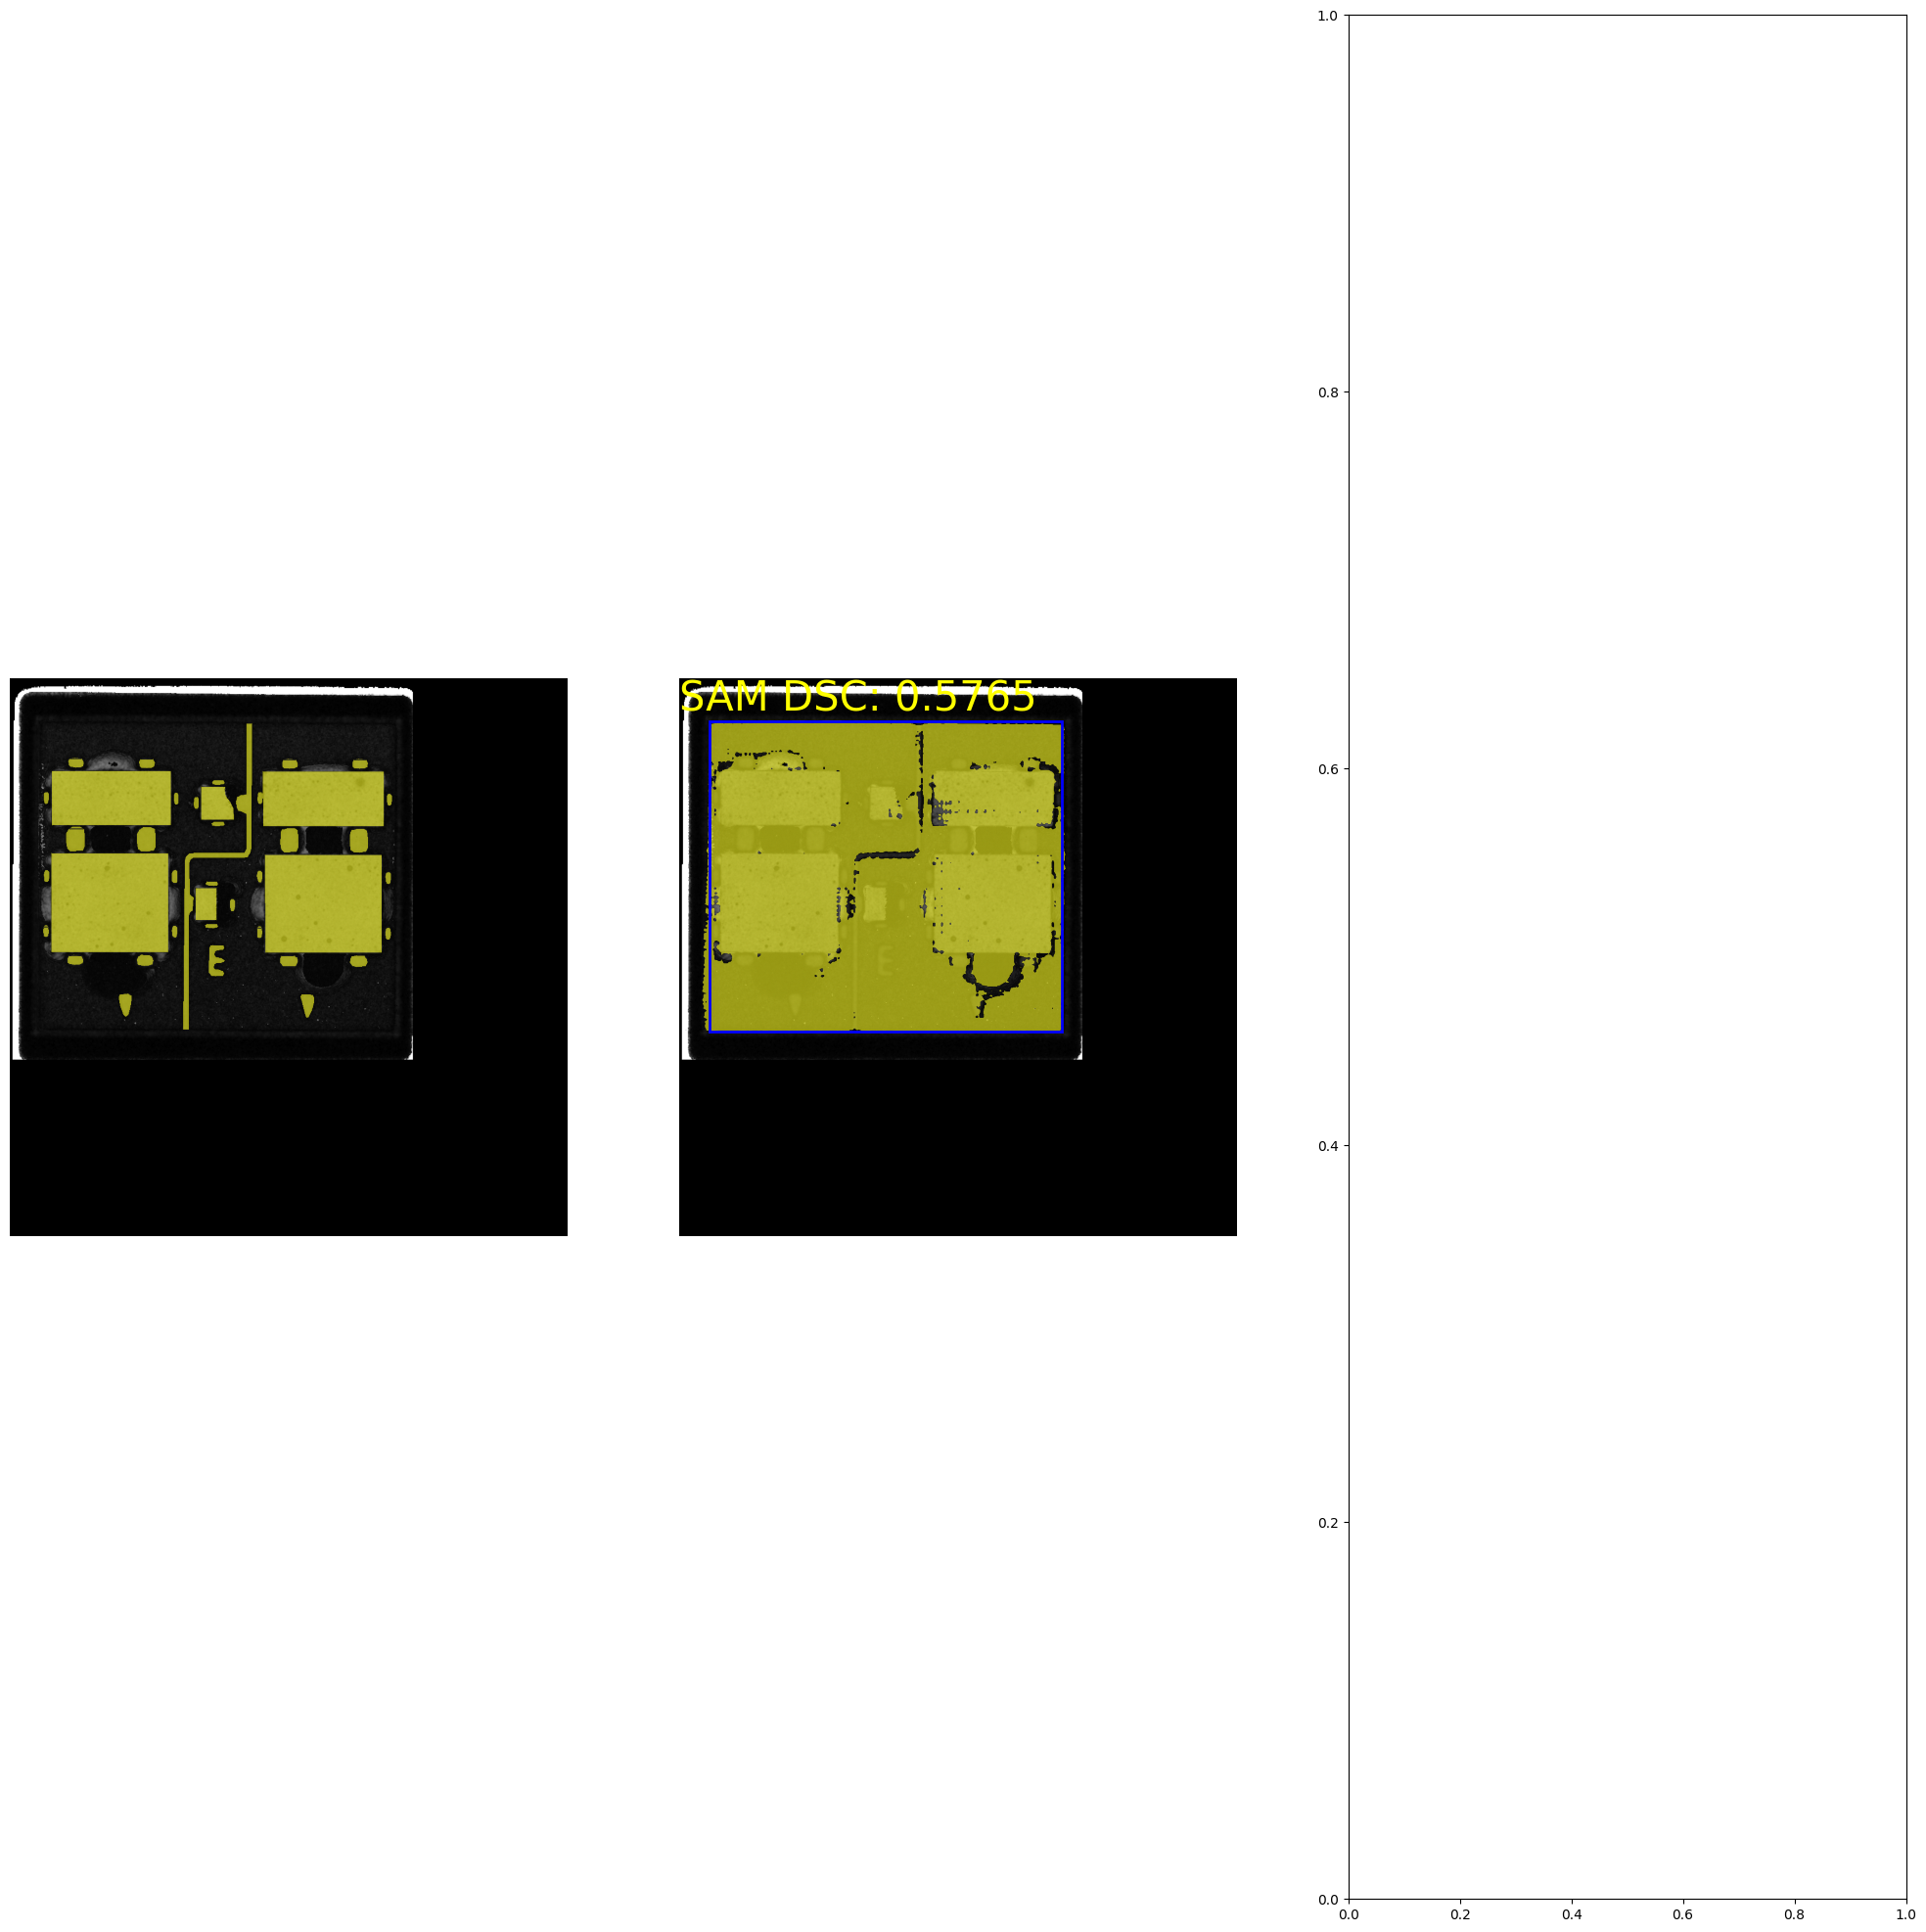

NameError: name 'test_npzs' is not defined

<Figure size 640x480 with 0 Axes>

In [35]:
##%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(gt_data>0, axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
show_box(bbox_raw, axs[1])
# add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

# axs[2].imshow(image_data)
# show_mask(cv2.resize(medsam_seg, (gt_data.shape)), axs[2])
# show_box(bbox_raw, axs[2])
# # add text to image to show dice score
# axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# # axs[2].set_title('Ground Truth', fontsize=20)
# axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()